# Classification of heart disease

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import pylab
import joblib
import collections
from time import time
from scipy import stats
from scipy.stats import norm
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
from sklearn.datasets import load_breast_cancer
from collections import Counter
from statsmodels.graphics.gofplots import qqplot
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

%config InlineBackend.figure_formats = ['retina']
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 42

In [4]:
sns.set_style('whitegrid')
%matplotlib inline
rcParams['figure.figsize'] = 10,8
pd.options.display.float_format = '{:.2f}'.format

**Data Description**: obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

age: The person's age in years


sex: The person's sex (1 = male, 0 = female)


cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)


trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)


chol: The person's cholesterol measurement in mg/dl


fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)


restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)


thalach: The person's maximum heart rate achieved


exang: Exercise induced angina (1 = yes; 0 = no)


oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)


slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)


ca: The number of major vessels (0-3) colored by flourosopy


thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)


target: Heart disease (0 = no, 1 = yes)


In [63]:
del heart

In [64]:
# reading the data
heart = pd.read_csv('/Users/audreyjo/Coding/Concert/python/practice/Heart_UCI/Sharma/heart.csv')
# getting the shape
heart.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0     2.30      0   
1   37    1   2       130   250    0        1      187      0     3.50      0   
2   41    0   1       130   204    0        0      172      0     1.40      2   
3   56    1   1       120   236    0        1      178      0     0.80      2   
4   57    0   0       120   354    0        1      163      1     0.60      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [65]:
heart.rename(columns={"cp": "chest_pain", "trestbps": "BP", "fbs":"blood_sugar", "restecg":"ECG", 
                      "thalach":"max_heart_rate", "exang":"exercise_induced_angina", "oldpeak":"st_depression", 
                      "ca":"n_vessels", "thal":"blood_disorder"}, inplace=True)

In [66]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      303 non-null    int64  
 1   sex                      303 non-null    int64  
 2   chest_pain               303 non-null    int64  
 3   BP                       303 non-null    int64  
 4   chol                     303 non-null    int64  
 5   blood_sugar              303 non-null    int64  
 6   ECG                      303 non-null    int64  
 7   max_heart_rate           303 non-null    int64  
 8   exercise_induced_angina  303 non-null    int64  
 9   st_depression            303 non-null    float64
 10  slope                    303 non-null    int64  
 11  n_vessels                303 non-null    int64  
 12  blood_disorder           303 non-null    int64  
 13  target                   303 non-null    int64  
dtypes: float64(1), int64(13)
m

In [67]:
#Dictionary
heart['sex'].replace({0:'Female',1:'Male'},inplace=True)
heart['chest_pain'].replace({1:'typical angina', 2:'atypical angina', 3:'non-anginal pain', 4:'asymptomatic'},inplace=True)
heart['blood_sugar'].replace({0:'lower than 120mg/ml', 1:'greater than 120mg/ml'},inplace=True)
heart['ECG'].replace({0:'normal', 1:'ST-T wave abnormality', 2:'left ventricular hypertrophy'},inplace=True)
heart['exercise_induced_angina'].replace({0:'no', 1:'yes'},inplace=True)
heart['slope'].replace({1: 'upsloping', 2:'flat', 0:'downsloping'},inplace=True)
heart['blood_disorder'].replace({1:'normal', 2:'fixed defect', 3:'reversable defect'},inplace=True)

In [46]:
# describing the data
heart.describe()

age     BP   chol  max_heart_rate  st_depression  n_vessels  target
count 303.00 303.00 303.00          303.00         303.00     303.00  303.00
mean   54.37 131.62 246.26          149.65           1.04       0.73    0.54
std     9.08  17.54  51.83           22.91           1.16       1.02    0.50
min    29.00  94.00 126.00           71.00           0.00       0.00    0.00
25%    47.50 120.00 211.00          133.50           0.00       0.00    0.00
50%    55.00 130.00 240.00          153.00           0.80       0.00    1.00
75%    61.00 140.00 274.50          166.00           1.60       1.00    1.00
max    77.00 200.00 564.00          202.00           6.20       4.00    1.00

## Step 1. Data exploration and visualization

In [8]:
# Check missing values
print(" \nCount total NaN at each column in a DataFrame : \n\n", heart.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 age                        0
sex                        0
chest_pain                 0
BP                         0
chol                       0
blood_sugar                0
ECG                        0
max_heart_rate             0
exercise_induced_angina    0
st_depression              0
slope                      0
n_vessels                  0
blood_disorder             0
target                     0
dtype: int64


In [7]:
for feature in ['sex', 'chest_pain', 'blood_sugar', 'ECG', 'exercise_induced_angina', 'slope', 
                'n_vessels', 'blood_disorder', 'target']:
    tab = pd.DataFrame()
    tab[feature]= heart.loc[:, [feature]]
    df = pd.concat([tab.value_counts(sort=False),              
    tab.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
    print (df)

        counts  percentage
sex                       
Female      96   31.683168
Male       207   68.316832
                  counts  percentage
chest_pain                          
0                    143   47.194719
atypical angina       87   28.712871
non-anginal pain      23    7.590759
typical angina        50   16.501650
                       counts  percentage
blood_sugar                              
greater than 120mg/ml      45   14.851485
lower than 120mg/ml       258   85.148515
                              counts  percentage
ECG                                             
ST-T wave abnormality            152   50.165017
left ventricular hypertrophy       4    1.320132
normal                           147   48.514851
                         counts  percentage
exercise_induced_angina                    
no                          204   67.326733
yes                          99   32.673267
             counts  percentage
slope                          
downsloping      

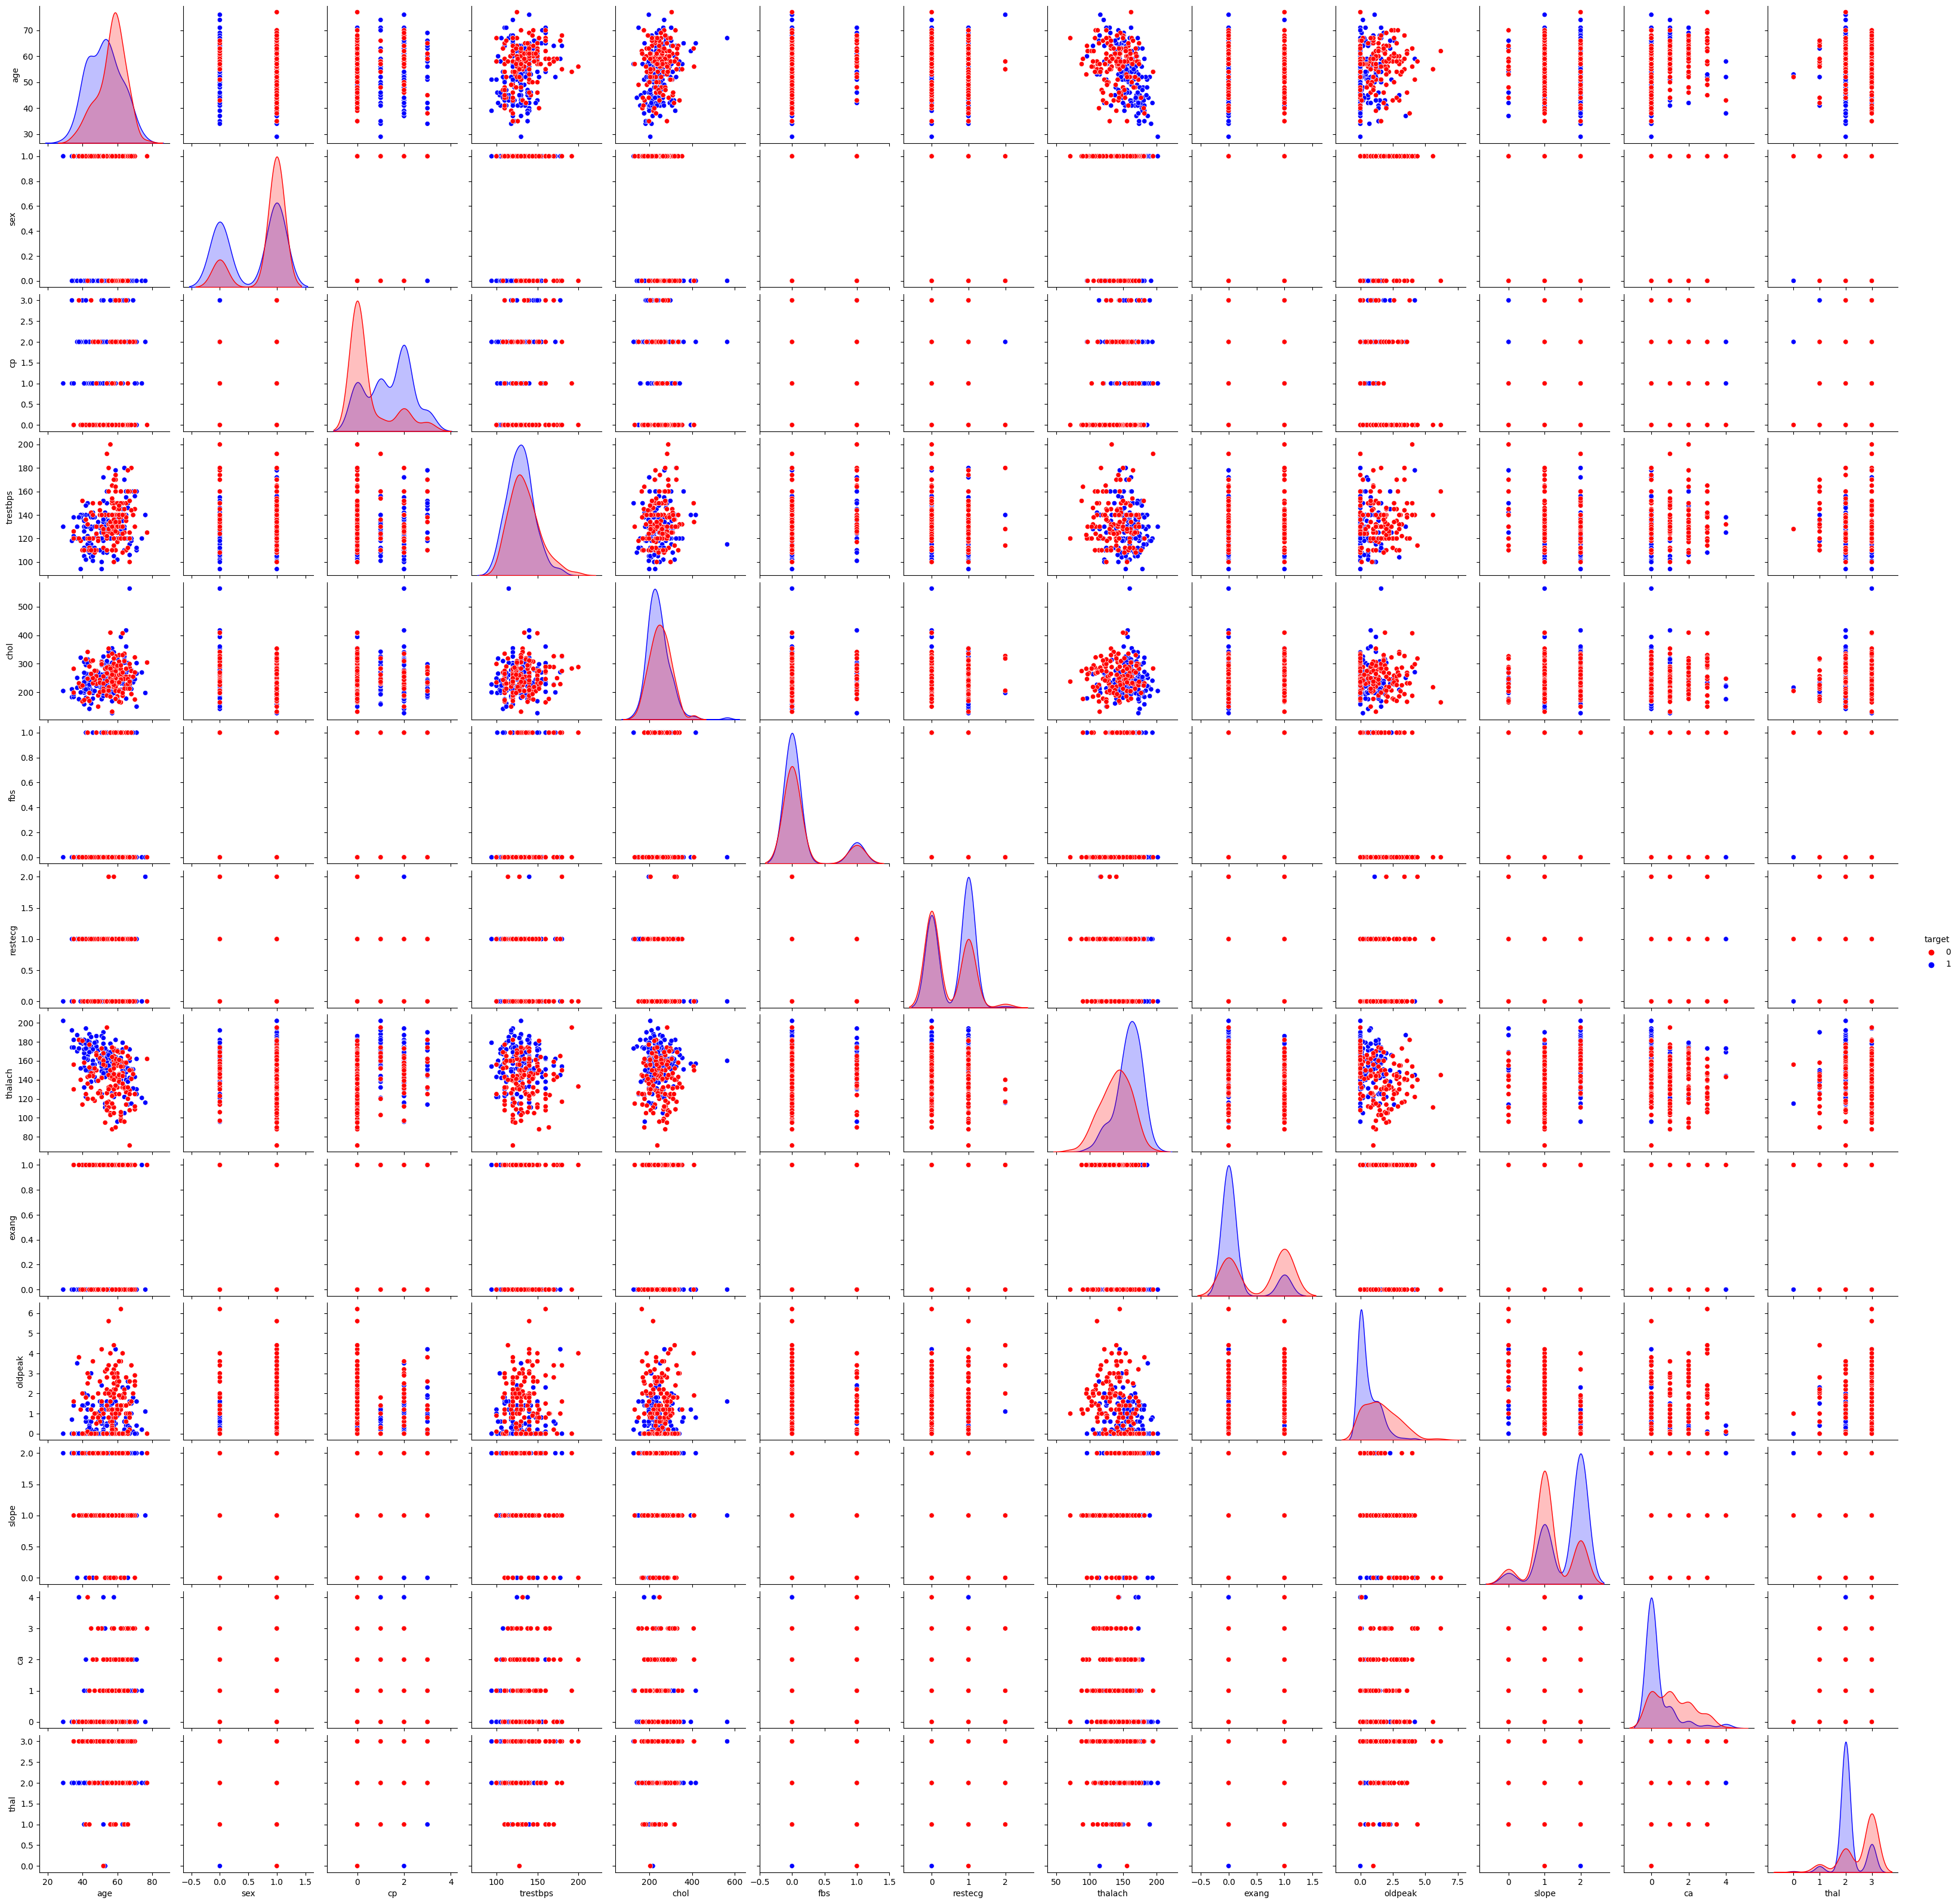

In [6]:
#Scatter plot by target
plt.rcParams['figure.figsize'] = (15, 15)
sns.pairplot(heart, hue='target', palette=["red", "blue"])   

<AxesSubplot: xlabel='age', ylabel='Density'>

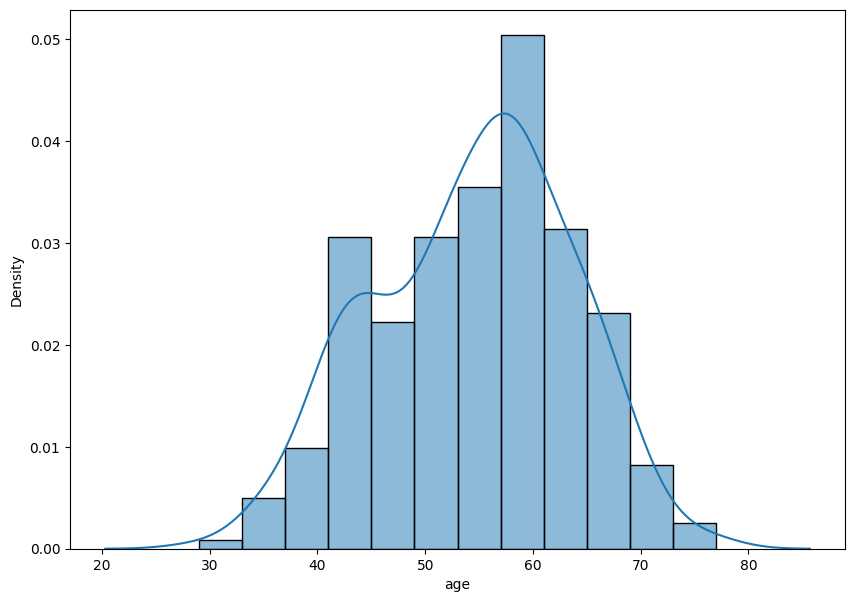

In [41]:
# histogram & Kernel density together: age amonng the patients
plt.rcParams['figure.figsize'] = (10, 7)
sns.histplot(
    heart["age"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)

In [10]:
# checking the values present in sex attribute
heart['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [130]:
heart['chest_pain'].value_counts()

asymptomatic        143
atypical angina      87
typical angina       50
non-anginal pain     23
Name: chest_pain, dtype: int64

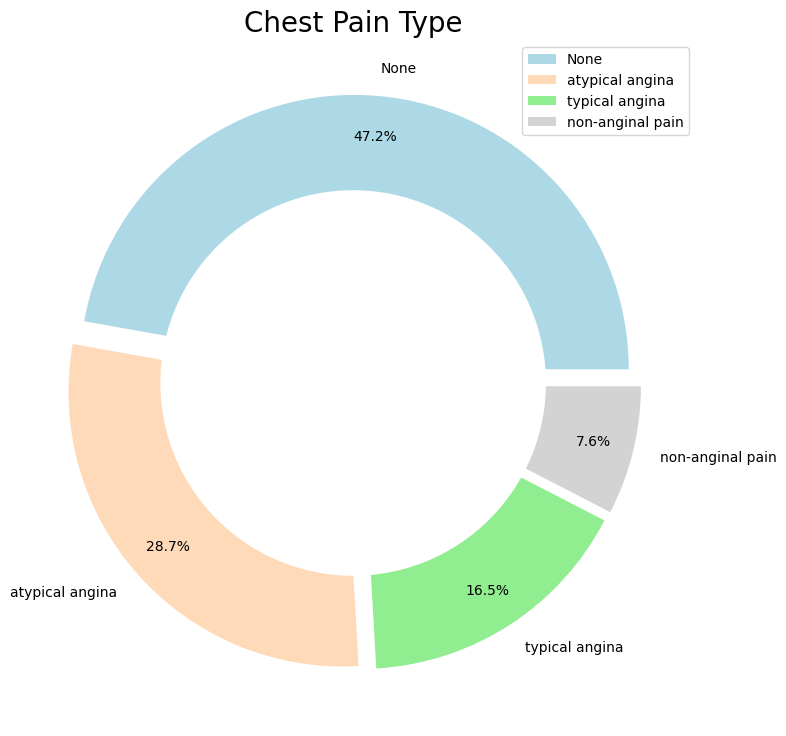

In [180]:
# plotting a donut chart for visualizing chest pain type
size = [143, 87, 50, 23]
colors = ['lightblue', 'peachpuff', 'lightgreen', 'lightgrey']
labels = "None", "atypical angina", "typical angina", "non-anginal pain"
explode = [0.05, 0.05, 0.05, 0.05]

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, labels = labels, pctdistance=0.85, explode = explode, autopct = '%.1f%%')
plt.title('Chest Pain Type', fontsize = 20)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Having heart disease')

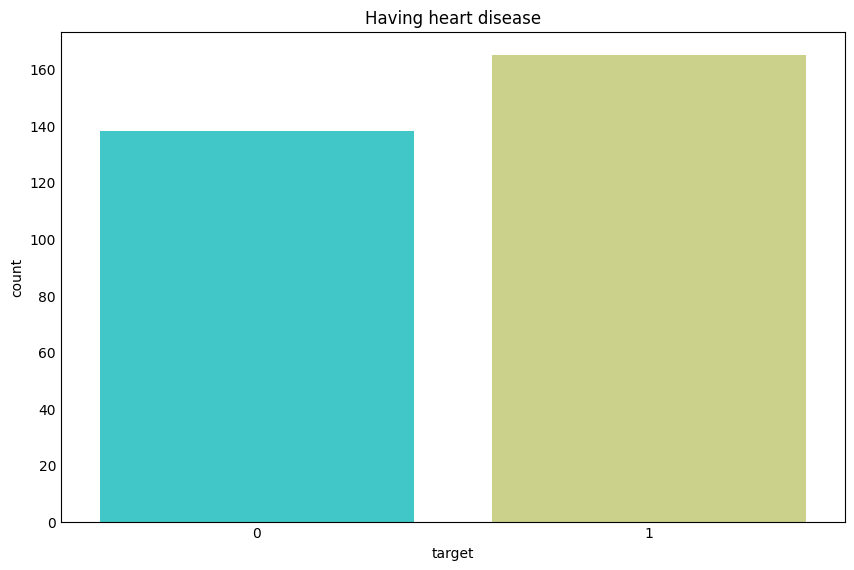

In [57]:
plt.figure(figsize=(8,5))
sns.countplot(x='target',data=heart, palette='rainbow')
plt.title("Having heart disease")

Text(0.5, 1.0, 'Relation of blood pressure with target')

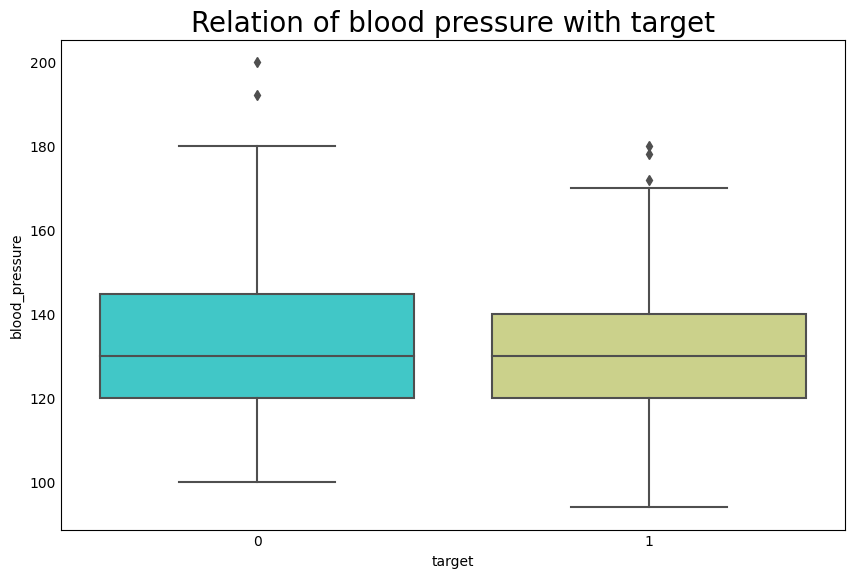

In [131]:
# tresbps vs target
plt.figure(figsize=(8,5))
sns.boxplot(x='target', y='blood_pressure', data=heart, palette='rainbow')
plt.title('Relation of blood pressure with target', fontsize = 20)

Text(0.5, 1.0, 'Relation of Cholestrol with Target')

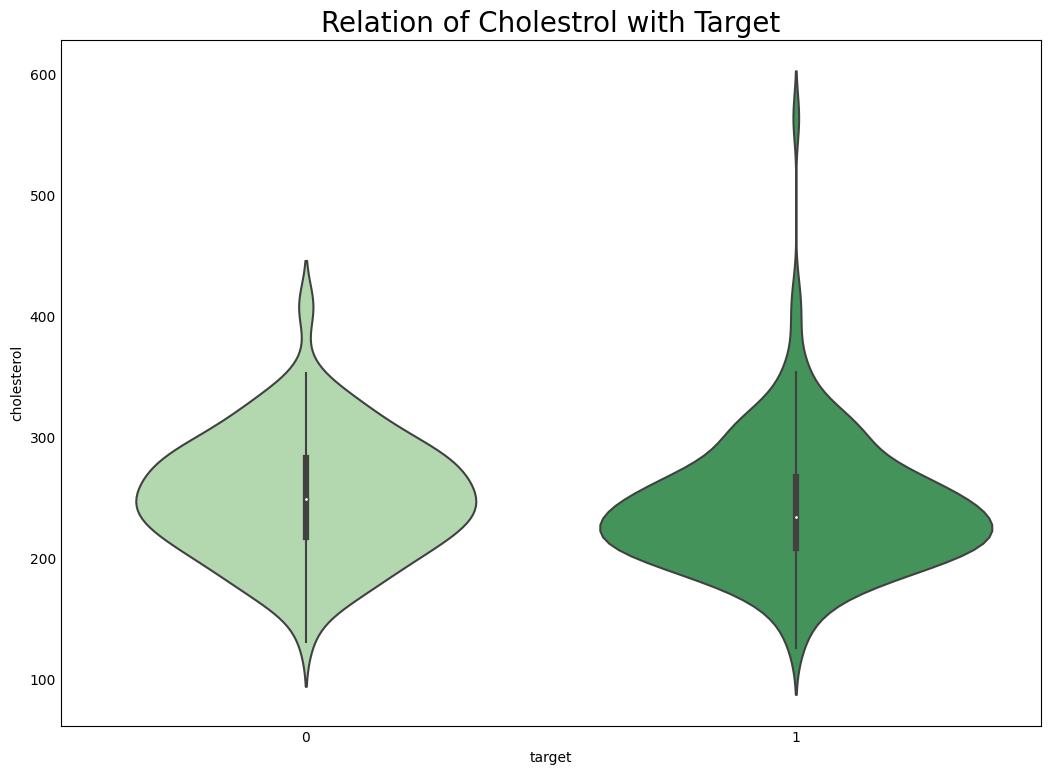

In [132]:
# cholestrol vs target
sns.violinplot(x=heart['target'], y=heart['cholesterol'], palette = "Greens")
plt.title('Relation of Cholestrol with Target', fontsize = 20)

Text(0.5, 1.0, 'Relation of ECG measurement with Target')

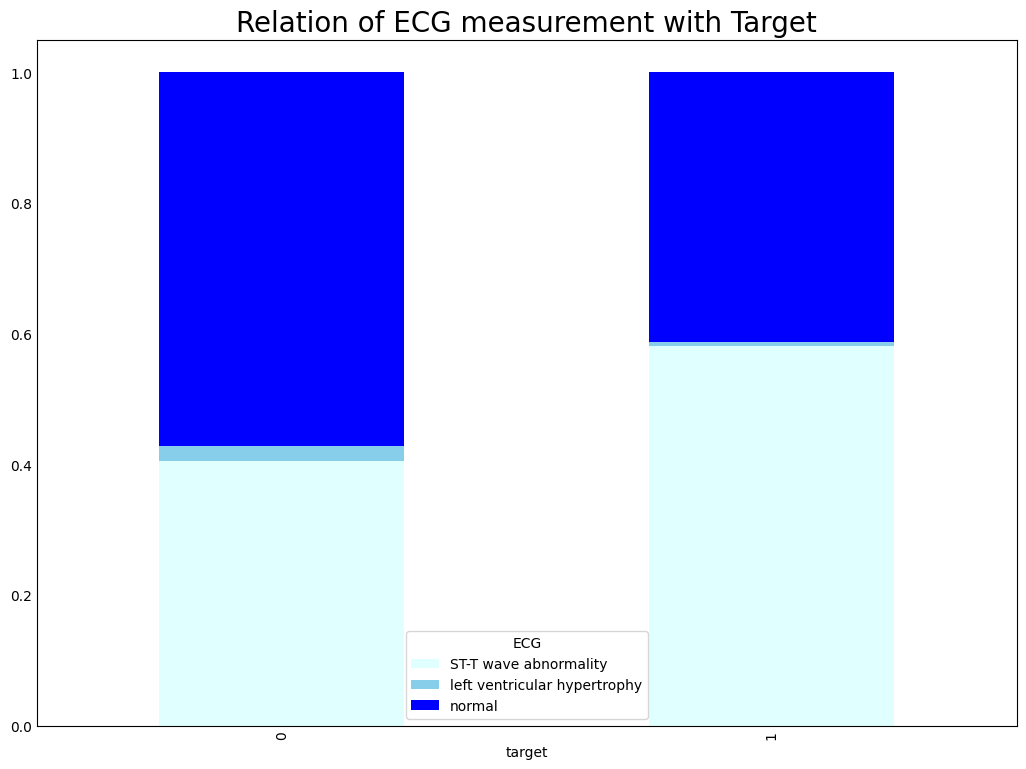

In [189]:
# Resting electrocardiographic measurement vs target
dat = pd.crosstab(index=heart['target'], columns=heart['ECG']) 
dat.div(dat.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 7), color = ['lightcyan', 'skyblue', 'blue'])
plt.title('Relation of ECG measurement with Target', fontsize = 20)

Text(0.5, 1.0, 'Relation between Max Heart rate and target')

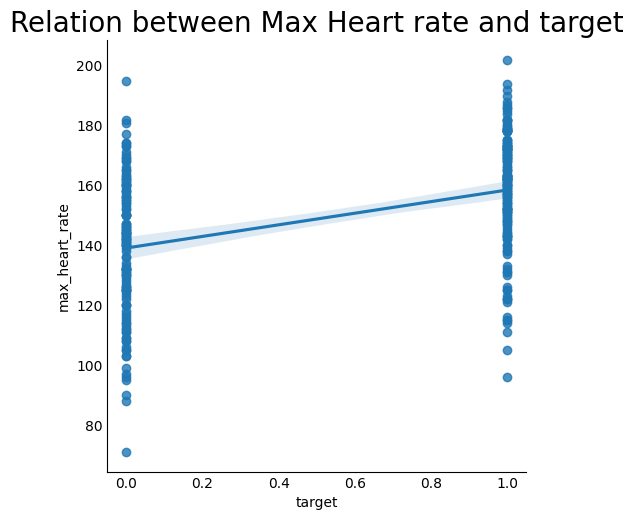

In [133]:
# checking the relation between max heart rate and target
plt.rcParams['figure.figsize'] = (10, 7)
sns.lmplot(x='target', y='max_heart_rate', data=heart)
plt.title('Relation between Max Heart rate and target', fontsize = 20)

In [136]:
heart['exercise_induced_angina'].value_counts()

no     204
yes     99
Name: exercise_induced_angina, dtype: int64

Text(0.5, 1.0, 'Relation between Max Heart rate and target')

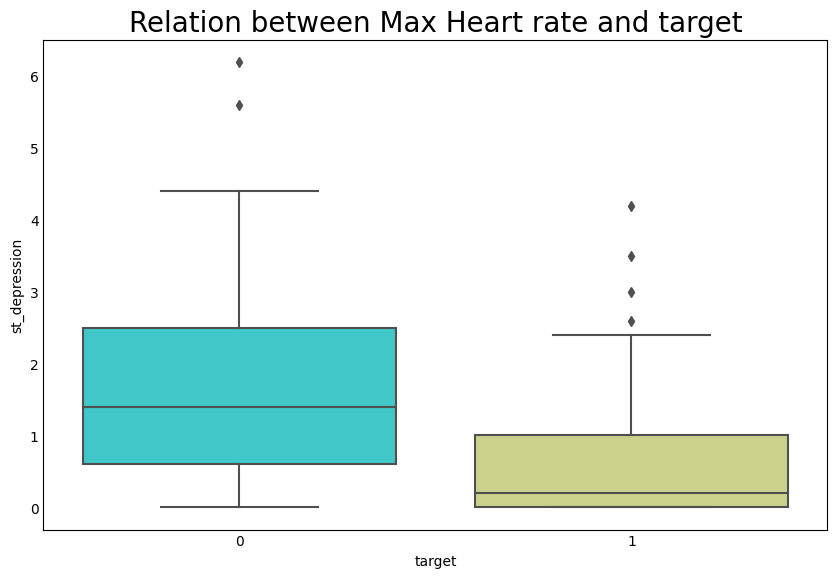

In [190]:
# tresbps vs target
plt.figure(figsize=(8,5))
sns.boxplot(x='target', y='st_depression', data=heart, palette='rainbow')
plt.title('Relation between Max Heart rate and target', fontsize = 20)

Text(0.5, 1.0, 'Relation of Sex and target')

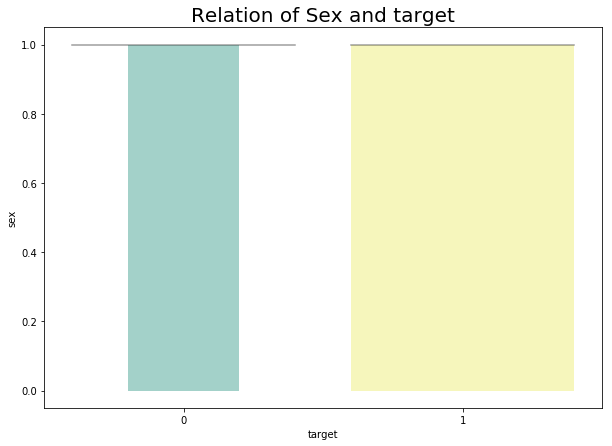

In [63]:
# relation between sex and target

sns.boxenplot(data['target'], data['sex'], palette = 'Set3')
plt.title('Relation of Sex and target', fontsize = 20)

Text(0.5, 1.0, 'Relation between Target and Blood disorder-Thalessemia')

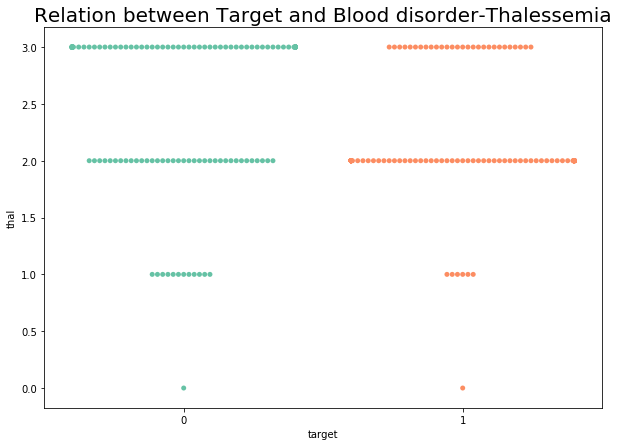

In [64]:
# checking the relation between 
#thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)

sns.swarmplot(data['target'], data['blood_disorder'], palette = 'Set2')
plt.title('Relation between Target and Blood disorder-Thalessemia', fontsize = 20)

Text(0.5, 1.0, 'Relation of target with cholestrol and thalessemia')

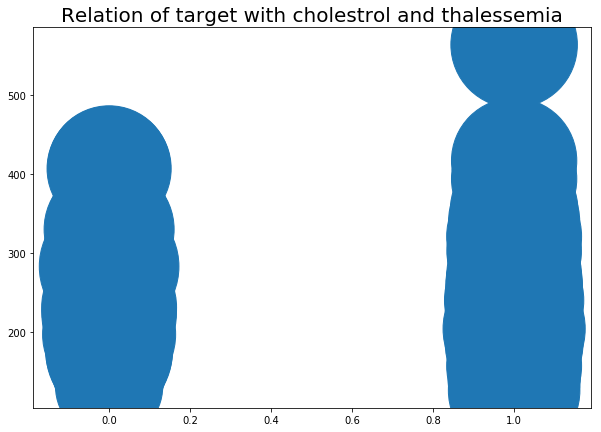

In [65]:
# target vs chol and hue = thalach

plt.scatter(x = data['target'], y = data['chol'], s = data['thalach']*100)
plt.title('Relation of target with cholestrol and thalessemia', fontsize = 20)

Text(0.5, 1.0, 'Checking relation of tresbps with genders to target')

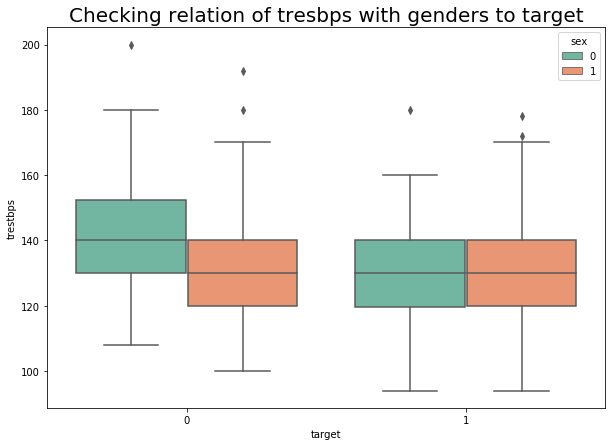

In [66]:
# multi-variate analysis

sns.boxplot(x = data['target'], y = data['trestbps'], hue = data['sex'], palette = 'Set2')
plt.title('Checking relation of tresbps with genders to target', fontsize = 20)

## Step 2. Feature engineering

In [68]:
heart['sex'] = heart['sex'].astype('object')
heart['chest_pain'] = heart['chest_pain'].astype('object')
heart['blood_sugar'] = heart['blood_sugar'].astype('object')
heart['ECG'] = heart['ECG'].astype('object')
heart['exercise_induced_angina'] = heart['exercise_induced_angina'].astype('object')
heart['slope'] = heart['slope'].astype('object')
heart['blood_disorder'] = heart['blood_disorder'].astype('object')

In [34]:
heart.describe()

age     BP   chol  max_heart_rate  st_depression  n_vessels  target
count 303.00 303.00 303.00          303.00         303.00     303.00  303.00
mean   54.37 131.62 246.26          149.65           1.04       0.73    0.54
std     9.08  17.54  51.83           22.91           1.16       1.02    0.50
min    29.00  94.00 126.00           71.00           0.00       0.00    0.00
25%    47.50 120.00 211.00          133.50           0.00       0.00    0.00
50%    55.00 130.00 240.00          153.00           0.80       0.00    1.00
75%    61.00 140.00 274.50          166.00           1.60       1.00    1.00
max    77.00 200.00 564.00          202.00           6.20       4.00    1.00

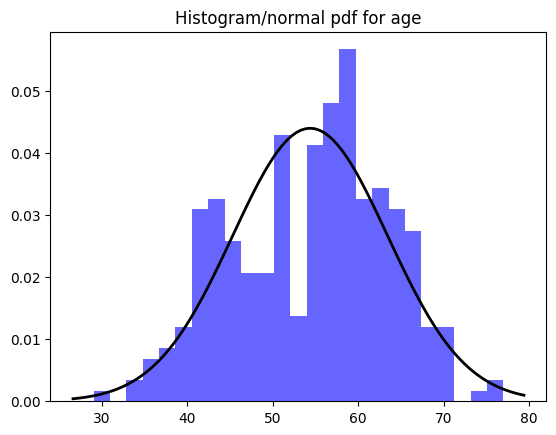

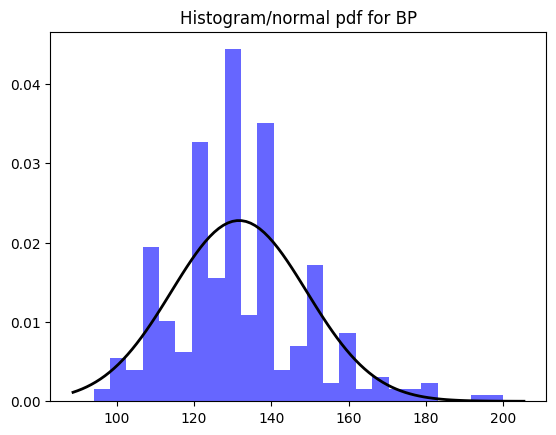

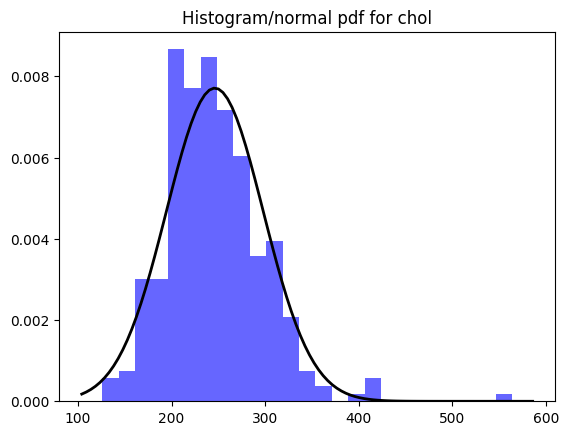

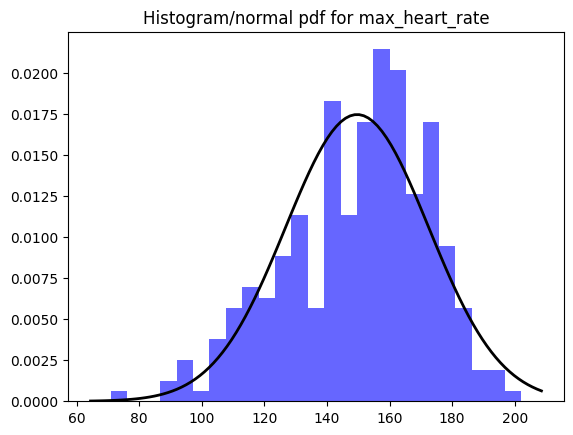

In [30]:
# Plot histogram for each continuous feature to see if a transformation is necessary
for feature in ['age', 'BP', 'chol', 'max_heart_rate']:
    mu, std = norm.fit(heart[feature])
    plt.hist(heart[feature], bins=25, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)  
    plt.plot(x, p, 'k', linewidth=2)
    plt.title('Histogram/normal pdf for {}'.format(feature))
    plt.show()

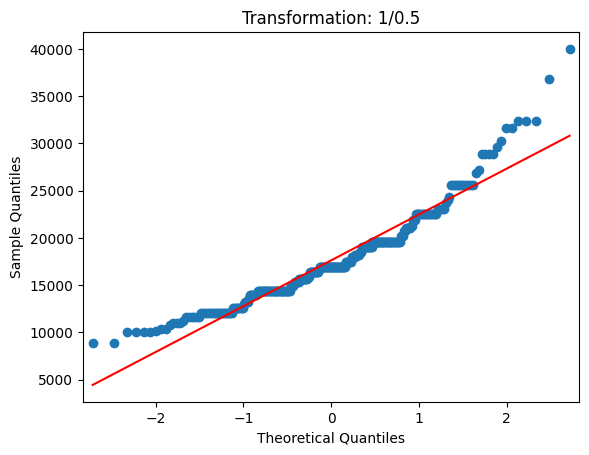

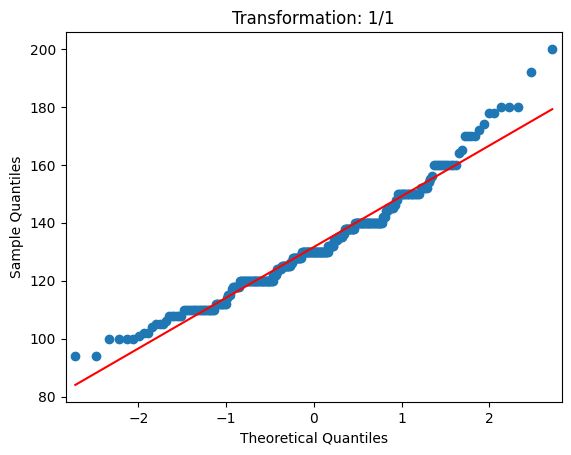

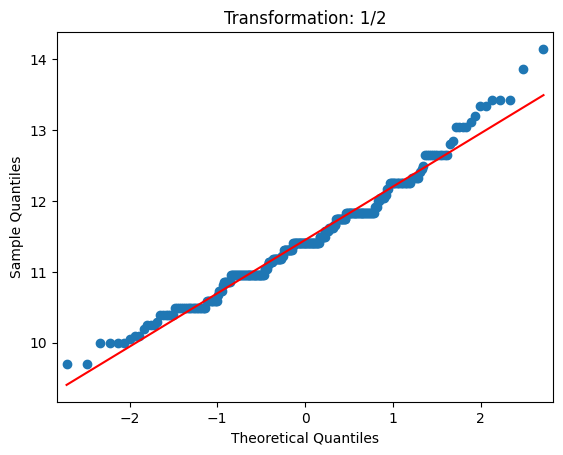

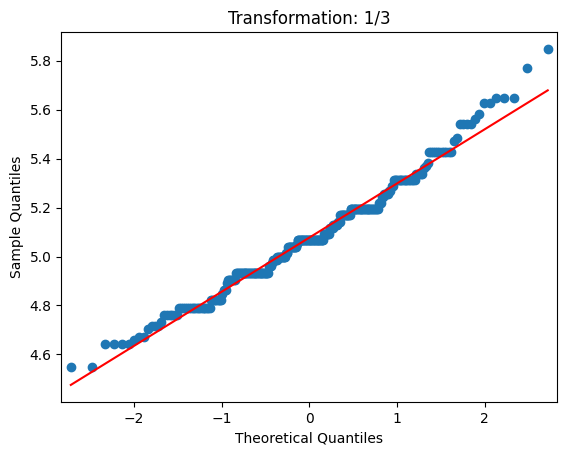

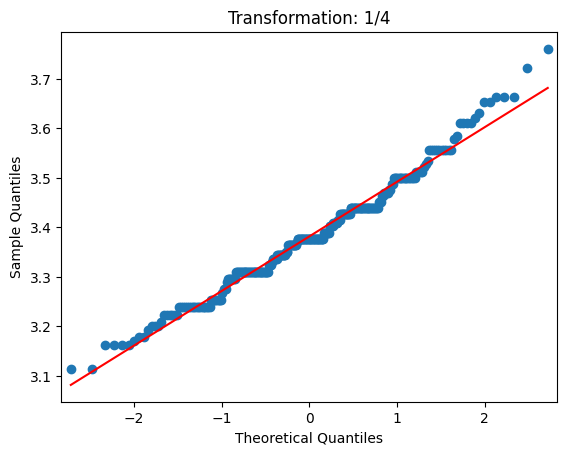

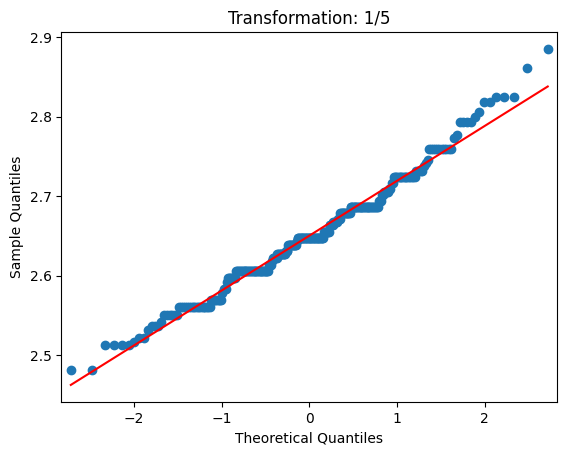

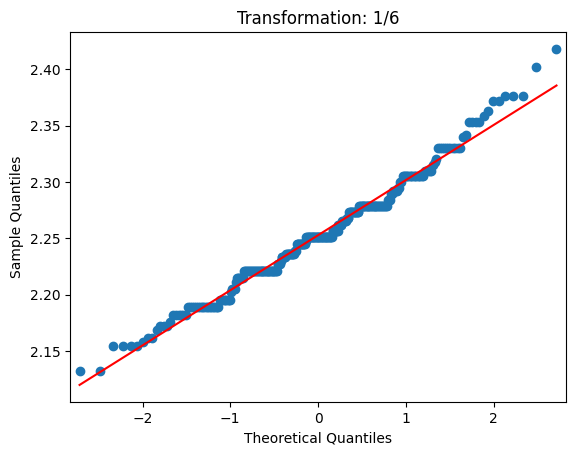

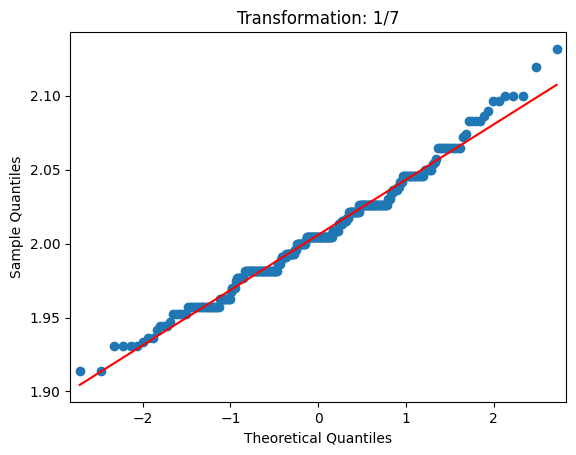

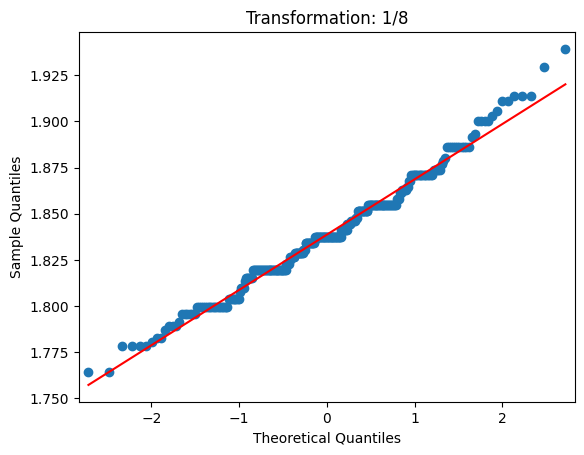

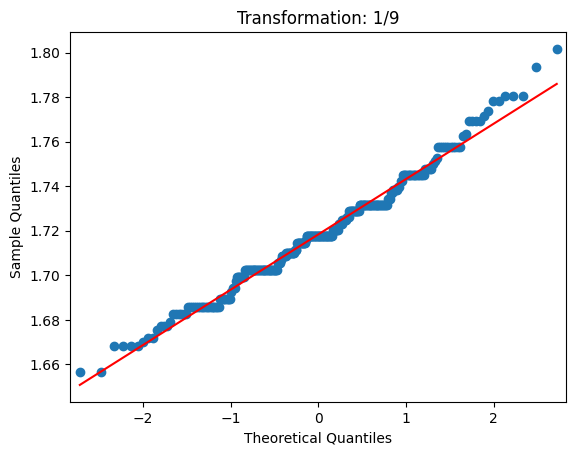

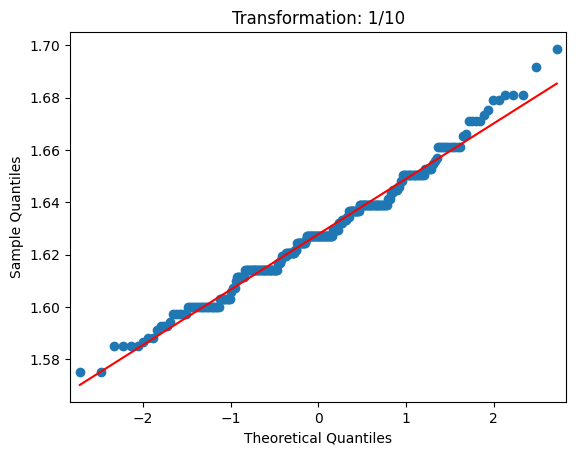

In [31]:
# which transforamtion yield the best behaved data. 
# Out of many criteria to be used (need to strudy later), 
# we here check QQ plots and historgram overlayed with normal distribution 
# Generate QQ plots: assume that perfect distribution would end up in a straight line
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = heart['BP']**(1/i)          
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))
# start getting well behaved 1/5

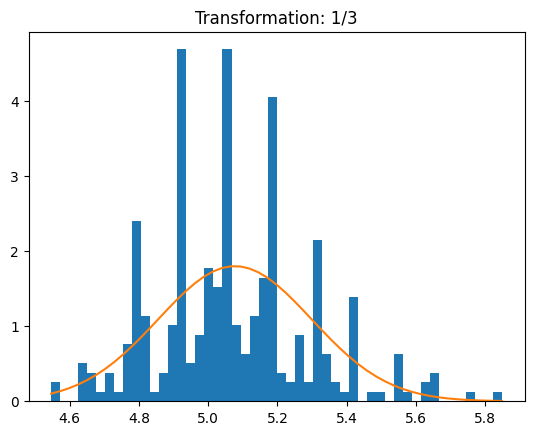

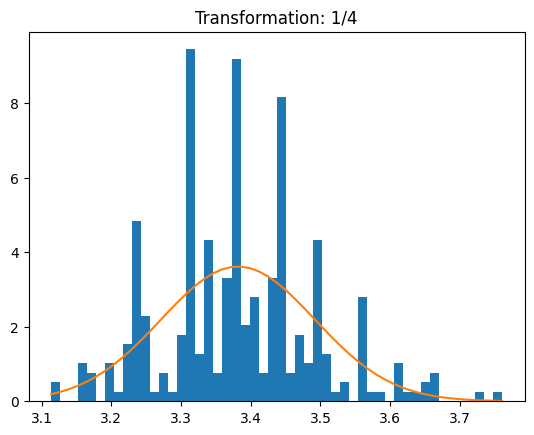

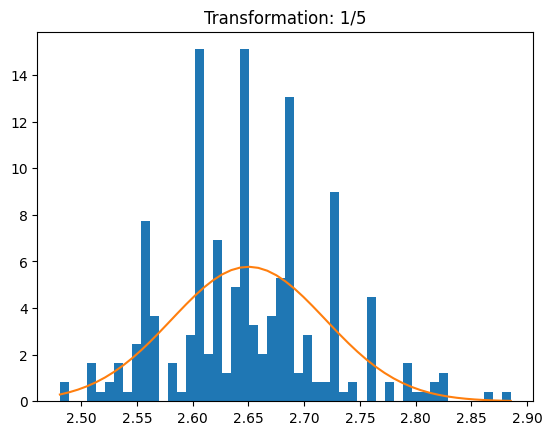

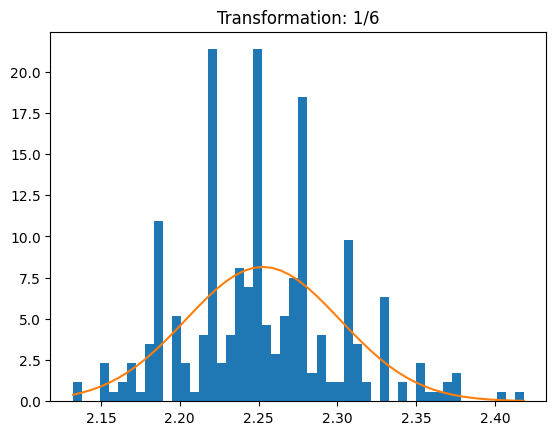

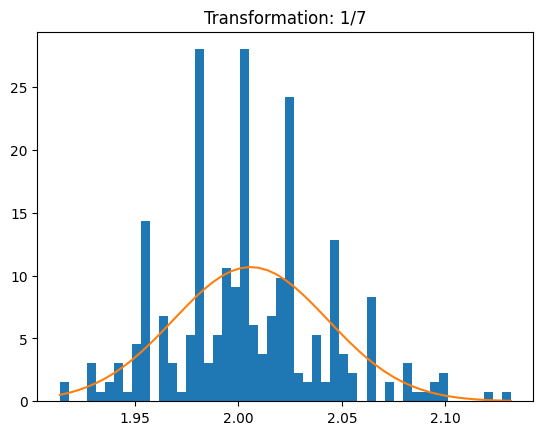

In [32]:
# Box-Cox transformation: from previous QQ plot, I selected 1/3, 1/4, 1/5, 1/6, 1/7
for i in [3, 4, 5, 6, 7]:
    data_t = heart['BP']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)                                 #calculate mean
    sigma = np.std(data_t)                               #calculate SD
    plt.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))# normal distribution
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()
# Interpretation of Result: None looks good, but any looks better than raw distribution

In [69]:
# Pick up 1/5 and Create the new transformed feature
heart['BP_tr'] = heart['BP'].apply(lambda x: x**(1/5))
heart.head()

age     sex        chest_pain   BP  chol            blood_sugar  \
0   63    Male  non-anginal pain  145   233  greater than 120mg/ml   
1   37    Male   atypical angina  130   250    lower than 120mg/ml   
2   41  Female    typical angina  130   204    lower than 120mg/ml   
3   56    Male    typical angina  120   236    lower than 120mg/ml   
4   57  Female                 0  120   354    lower than 120mg/ml   

                     ECG  max_heart_rate exercise_induced_angina  \
0                 normal             150                      no   
1  ST-T wave abnormality             187                      no   
2                 normal             172                      no   
3  ST-T wave abnormality             178                      no   
4  ST-T wave abnormality             163                     yes   

   st_depression        slope  n_vessels blood_disorder  target  BP_tr  
0           2.30  downsloping          0         normal       1   2.71  
1           3.50  downsloping          0   fixed defect       1   2.65  
2           1.40         flat          0   fixed defect       1   2.65  
3           0.80         flat          0   fixed defect       1   2.61  
4           0.60         flat          0   fixed defect       1   2.61

### Convert string to dummy

In [70]:
# one hot encoding of the data
# drop_first = True, means dropping the first categories from each of the attribues 
# for example, gender having gender_male and gender-female would be male having values 1 and 0
heart = pd.get_dummies(heart, drop_first=True)
heart.head()

age   BP  chol  max_heart_rate  st_depression  n_vessels  target  BP_tr  \
0   63  145   233             150           2.30          0       1   2.71   
1   37  130   250             187           3.50          0       1   2.65   
2   41  130   204             172           1.40          0       1   2.65   
3   56  120   236             178           0.80          0       1   2.61   
4   57  120   354             163           0.60          0       1   2.61   

   sex_Male  chest_pain_atypical angina  ...  chest_pain_typical angina  \
0         1                           0  ...                          0   
1         1                           1  ...                          0   
2         0                           0  ...                          1   
3         1                           0  ...                          1   
4         0                           0  ...                          0   

   blood_sugar_lower than 120mg/ml  ECG_left ventricular hypertrophy  \
0                                0                                 0   
1                                1                                 0   
2                                1                                 0   
3                                1                                 0   
4                                1                                 0   

   ECG_normal  exercise_induced_angina_yes  slope_flat  slope_upsloping  \
0           1                            0           0                0   
1           0                            0           0                0   
2           1                            0           1                0   
3           0                            0           1                0   
4           0                            1           1                0   

   blood_disorder_fixed defect  blood_disorder_normal  \
0                            0                      1   
1                            1                      0   
2                            1                      0   
3                            1                      0   
4                            1                      0   

   blood_disorder_reversable defect  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 21 columns]

### Check correlation

In [71]:
matrix = heart.corr(numeric_only=True).round(2)
matrix2 = matrix.unstack()
matrix2= matrix2[(abs(matrix2)>=0.7) & (abs(matrix2) < 1)]
matrix2

slope_flat                        slope_upsloping                    -0.87
slope_upsloping                   slope_flat                         -0.87
blood_disorder_fixed defect       blood_disorder_reversable defect   -0.87
blood_disorder_reversable defect  blood_disorder_fixed defect        -0.87
dtype: float64

<AxesSubplot: >

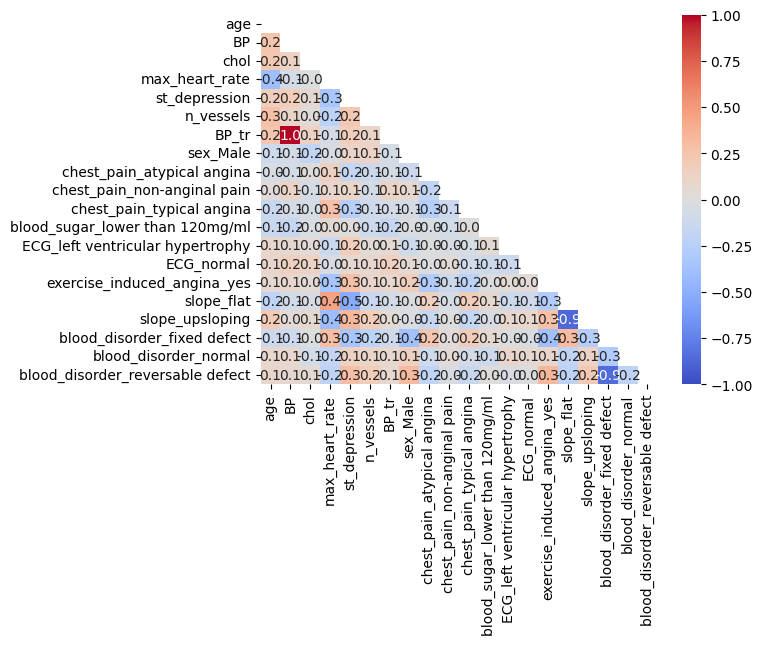

In [43]:
# Generate correlation matrix heat map
mask = np.triu(heart.corr())
sns.heatmap(heart.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm', mask=mask)

In [73]:
#drop columns w/ strong correlation
feat=['BP', 'blood_disorder_reversable defect', 'slope_upsloping']
heart.drop(feat, axis = 1, inplace=True)

In [74]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               303 non-null    int64  
 1   chol                              303 non-null    int64  
 2   max_heart_rate                    303 non-null    int64  
 3   st_depression                     303 non-null    float64
 4   n_vessels                         303 non-null    int64  
 5   target                            303 non-null    int64  
 6   BP_tr                             303 non-null    float64
 7   sex_Male                          303 non-null    uint8  
 8   chest_pain_atypical angina        303 non-null    uint8  
 9   chest_pain_non-anginal pain       303 non-null    uint8  
 10  chest_pain_typical angina         303 non-null    uint8  
 11  blood_sugar_lower than 120mg/ml   303 non-null    uint8  
 12  ECG_left

## Step 3. BUILD MODELS

In [78]:
y = heart['target']
x = heart.drop('target', axis = 1)
x.head()

age  chol  max_heart_rate  st_depression  n_vessels  BP_tr  sex_Male  \
0   63   233             150           2.30          0   2.71         1   
1   37   250             187           3.50          0   2.65         1   
2   41   204             172           1.40          0   2.65         0   
3   56   236             178           0.80          0   2.61         1   
4   57   354             163           0.60          0   2.61         0   

   chest_pain_atypical angina  chest_pain_non-anginal pain  \
0                           0                            1   
1                           1                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   chest_pain_typical angina  blood_sugar_lower than 120mg/ml  \
0                          0                                0   
1                          0                                1   
2                          1                                1   
3                          1                                1   
4                          0                                1   

   ECG_left ventricular hypertrophy  ECG_normal  exercise_induced_angina_yes  \
0                                 0           1                            0   
1                                 0           0                            0   
2                                 0           1                            0   
3                                 0           0                            0   
4                                 0           0                            1   

   slope_flat  blood_disorder_fixed defect  blood_disorder_normal  
0           0                            0                      1  
1           0                            1                      0  
2           1                            1                      0  
3           1                            1                      0  
4           1                            1                      0

In [77]:
# checking the shapes of x and y
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (303, 17)
Shape of y: (303,)


In [79]:
y.value_counts()

1    165
0    138
Name: target, dtype: int64

### Split data

In [80]:
# splitting the sets into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
# getting the shapes
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (242, 17)
Shape of x_test : (61, 17)
Shape of y_train : (242,)
Shape of y_test : (61,)


### Standardize All Features

In [81]:
# Fit the scaler on the training data=means computing mean and SD fo each individual feature of train data
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [82]:
# Scale the training, test, and validation sets
# Tell scaler the explicit colums we want to transform: store column names, which are usable for train, val, test data sets
features = x_train.columns       

x_train[features] = scaler.transform(x_train[features])
x_test[features] = scaler.transform(x_test[features])

x_train.head()

age  chol  max_heart_rate  st_depression  n_vessels  BP_tr  sex_Male  \
74  -1.33 -0.63            0.66          -0.72      -0.71  -0.55     -1.44   
153  1.25  0.59            0.09          -0.89       0.27   0.86     -1.44   
64   0.35 -0.67            0.66          -0.89      -0.71   0.53      0.70   
296  0.91 -0.93           -0.60          -0.89      -0.71  -0.42     -1.44   
287  0.24 -0.28            0.61          -0.89       0.27   1.29      0.70   

     chest_pain_atypical angina  chest_pain_non-anginal pain  \
74                         1.58                        -0.30   
153                        1.58                        -0.30   
64                         1.58                        -0.30   
296                       -0.63                        -0.30   
287                       -0.63                        -0.30   

     chest_pain_typical angina  blood_sugar_lower than 120mg/ml  \
74                       -0.42                             0.42   
153                      -0.42                             0.42   
64                       -0.42                            -2.39   
296                      -0.42                             0.42   
287                       2.39                             0.42   

     ECG_left ventricular hypertrophy  ECG_normal  \
74                              -0.13       -0.99   
153                             -0.13        1.01   
64                              -0.13        1.01   
296                             -0.13       -0.99   
287                             -0.13        1.01   

     exercise_induced_angina_yes  slope_flat  blood_disorder_fixed defect  \
74                         -0.71       -0.96                         0.90   
153                        -0.71       -0.96                         0.90   
64                         -0.71        1.04                         0.90   
296                         1.41       -0.96                         0.90   
287                        -0.71        1.04                         0.90   

     blood_disorder_normal  
74                   -0.27  
153                  -0.27  
64                   -0.27  
296                  -0.27  
287                  -0.27

### Baseline models

In [99]:
# KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# to give model baseline report in dataframe 
def baseline_report(model, x_train, x_test, y_train, y_test, name):
    model.fit(x_train, y_train)
    accuracy     = np.mean(cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, x_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, x_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, x_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, x_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(x_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    base_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return base_model

# to evaluate baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
pre_svc = SVC()
svc = CalibratedClassifierCV(pre_svc) 
pre_lsvc = LinearSVC()
linearsvc = CalibratedClassifierCV(pre_lsvc) 

# to concat all models
base_models = pd.concat([baseline_report(gnb, x_train, x_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(bnb, x_train, x_test, y_train, y_test, 'BernoulliNB'),
                       baseline_report(logit, x_train, x_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, x_train, x_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, x_train, x_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(randomforest, x_train, x_test, y_train, y_test, 'RandomForest'),
                       baseline_report(svc, x_train, x_test, y_train, y_test, 'SVC'),
                       baseline_report(linearsvc, x_train, x_test, y_train, y_test, 'LinearSVC')
                       ], axis=0).reset_index()
base_models = base_models.drop('index', axis=1)
base_models

/Users/audreyjo/Coding/Concert/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/audreyjo/Coding/Concert/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/audreyjo/Coding/Concert/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/audreyjo/Coding/Concert/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/audreyjo/Coding/Concert/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/audreyjo/Codi

model  accuracy  precision  recall  f1score  rocauc  logloss  \
0          GaussianNB      0.72       0.74    0.77     0.73    0.84     8.27   
1         BernoulliNB      0.82       0.83    0.84     0.83    0.91     6.50   
2  LogisticRegression      0.82       0.81    0.86     0.84    0.89     5.32   
3                 KNN      0.79       0.80    0.80     0.80    0.84     4.73   
4        DecisionTree      0.75       0.77    0.76     0.76    0.75     9.45   
5        RandomForest      0.81       0.81    0.84     0.84    0.89     6.50   
6                 SVC      0.77       0.78    0.81     0.79    0.87     4.73   
7           LinearSVC      0.83       0.82    0.87     0.84    0.89     5.32   

   timetaken  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0

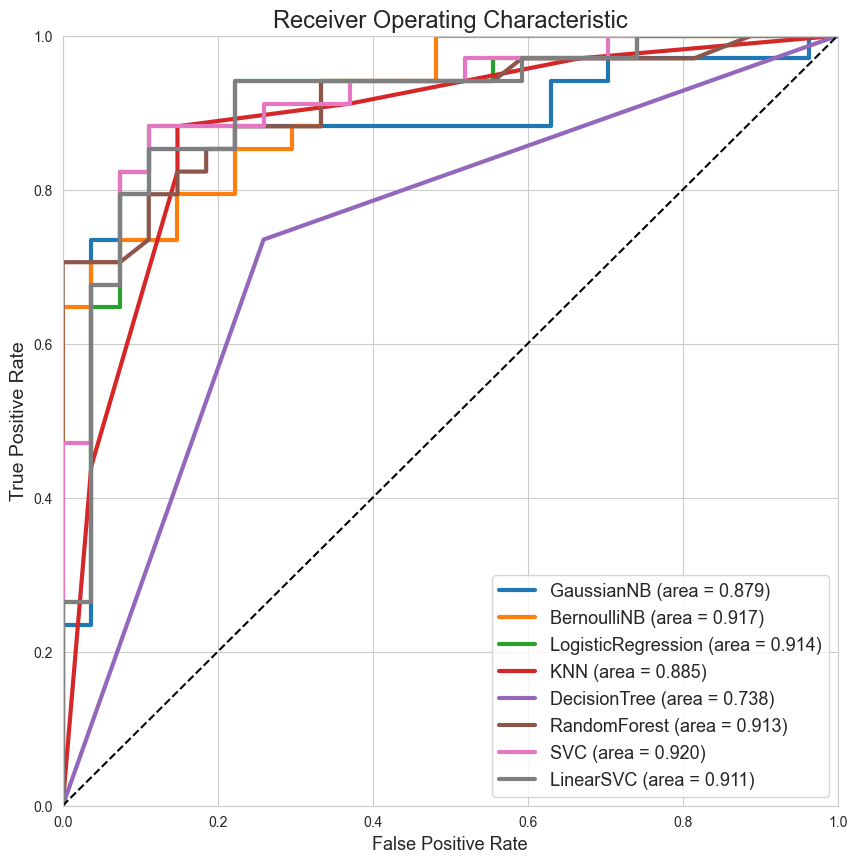

In [102]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=base_models.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

## Step 4. Optimise model

In [108]:
def model_report(model, x_train, x_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(x_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21),
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(x_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(x_train, y_train)))  # score uses accuracy
    accuracy      = model.score(x_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(x_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(x_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(x_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(x_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(x_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    imp_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return imp_model

In [109]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, x_train, x_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, x_train, x_test, y_train, y_test, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7253,  0.100->0.8000,  0.200->0.8000,  0.300->0.8000,  0.400->0.8108,  0.500->0.8108,  0.600->0.8529,  0.700->0.8529,  0.800->0.8788,  0.900->0.8615,  1.000->0.4444,  
Looping decimal place 2
0.700->0.8529,  0.710->0.8529,  0.720->0.8529,  0.730->0.8529,  0.740->0.8529,  0.750->0.8529,  0.760->0.8657,  0.770->0.8657,  0.780->0.8657,  0.790->0.8657,  0.800->0.8788,  0.810->0.8788,  0.820->0.8788,  0.830->0.8788,  0.840->0.8788,  0.850->0.8788,  0.860->0.8788,  0.870->0.8788,  0.880->0.8788,  0.890->0.8788,  0.900->0.8615,  
Looping decimal place 3
0.790->0.8657,  0.791->0.8788,  0.792->0.8788,  0.793->0.8788,  0.794->0.8788,  0.795->0.8788,  0.796->0.8788,  0.797->0.8788,  0.798->0.8788,  0.799->0.8788,  0.800->0.8788,  0.801->0.8788,  0.802->0.8788,  0.803->0.8788,  0.804->0.8788,  0.805->0.8788,  0.806->0.8788,  0.807->0.8788,  0.808->0.

In [110]:
print('\n"""""" LogisticRegression """"""')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, x_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, x_train, x_test, y_train, y_test, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.7863, 0.7953, 0.7969, 0.8064, 0.8137, 0.8155, 0.8145, 0.8172, 0.8259, 0.8284, 0.8309, 0.8321, 0.8377, 0.8397, 0.8397, 0.8423, 0.8450, 0.8478, 0.8478, 0.8510, 0.8510, 0.8468, 0.8421, 0.8453, 0.8486, 0.8442, 0.8472, 0.8431, 0.8395, 0.8395, 0.8395, 0.8395, 0.8428, 0.8457, 0.8457, 0.8457, 0.8491, 0.8446, 0.8446, 0.8446, 0.8482, 0.8482, 0.8527, 0.8527, 0.8527, 0.8527, 0.8527, 0.8527, 0.8563, 0.8563, 0.8563, 0.8563, 0.8563, 0.8563, 0.8563, 0.8563, 0.8563, 0.8517, 0.8517, 0.8517, 0.8482, 0.8482, 0.8482, 0.8482, 0.8482, 0.8522, 0.8522, 0.8522, 0.8522, 0.8488, 0.8488, 0.8457, 0.8422, 0.8452, 0.8482, 0.8482, 0.8482, 0.8482, 0.8482, 0.8434, 0.8468, 0.8468, 0.8468, 0.8468, 0.8468, 0.8468, 0.8468, 0.8468, 0.8468, 0.8428, 0.8428, 0.8428, 0.8379, 0.8379, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 0.8327, 

In [112]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, x_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, x_train, x_test, y_train, y_test, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.7524, 0.7167, 0.7853, 0.7600, 0.8103, 0.8242, 0.8117, 0.8038, 0.8308, 0.8159, 0.8219, 0.8238, 0.8227, 0.8167, 0.8273, 0.8252, 0.8289, 0.8299, 0.8291, 0.8219, optimal cv F1 score = 0.8308
optimal value of K = 9

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7556,  0.100->0.7556,  0.200->0.7805,  0.300->0.8052,  0.400->0.8333,  0.500->0.8696,  0.600->0.8615,  0.700->0.8333,  0.800->0.6275,  0.900->0.3810,  1.000->0.3810,  
Looping decimal place 2
0.400->0.8333,  0.410->0.8333,  0.420->0.8333,  0.430->0.8333,  0.440->0.8333,  0.450->0.8696,  0.460->0.8696,  0.470->0.8696,  0.480->0.8696,  0.490->0.8696,  0.500->0.8696,  0.510->0.8696,  0.520->0.8696,  0.530->0.8696,  0.540->0.8696,  0.550->0.8696,  0.560->0.8615,  0.570->0.8615,  0.580->0.8615,  0.590->0.8615,  0.600->0.8615,  
Loo

In [113]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, x_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, x_train, x_test, y_train, y_test, 'DecisionTree')
model6.timetaken[0] = time.time() - time1


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.7074, 0.7788, 0.8071, 0.7883, 0.7869, 0.7787, 0.7654, 0.7726, 0.7585, optimal F1 score = 0.8071
optimal max_depth = 4

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7158,  0.100->0.7848,  0.200->0.8056,  0.300->0.7879,  0.400->0.7879,  0.500->0.7879,  0.600->0.7879,  0.700->0.7879,  0.800->0.7368,  0.900->0.6792,  1.000->0.1579,  
Looping decimal place 2
0.100->0.7848,  0.110->0.7848,  0.120->0.7838,  0.130->0.7838,  0.140->0.8056,  0.150->0.8056,  0.160->0.8056,  0.170->0.8056,  0.180->0.8056,  0.190->0.8056,  0.200->0.8056,  0.210->0.8056,  0.220->0.8056,  0.230->0.8056,  0.240->0.8056,  0.250->0.8056,  0.260->0.8056,  0.270->0.8056,  0.280->0.8056,  0.290->0.7879,  0.300->0.7879,  
Looping decimal place 3
0.130->0.7838,  0.131->0.7838,  0.132->0.7838,  0.133->0.7

In [114]:
print('\n"""""" RandomForestClassifier """"""')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=42, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, x_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, x_train, x_test, y_train, y_test, 'RandomForest')
model7.timetaken[0] = time.time() - time1


"""""" RandomForestClassifier """"""

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.8282, 150->0.8271, 200->0.8269, 250->0.8344, 300->0.8232, 350->0.8299, 400->0.8232, 450->0.8294, 500->0.8377, optimal F1 score = 0.8377
optimal n_estimators = 500

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7158,  0.100->0.7640,  0.200->0.8148,  0.300->0.8158,  0.400->0.8611,  0.500->0.8696,  0.600->0.8308,  0.700->0.7170,  0.800->0.6400,  0.900->0.4889,  1.000->0.0000,  
Looping decimal place 2
0.400->0.8611,  0.410->0.8732,  0.420->0.8732,  0.430->0.8732,  0.440->0.8571,  0.450->0.8571,  0.460->0.8571,  0.470->0.8571,  0.480->0.8571,  0.490->0.8571,  0.500->0.8696,  0.510->0.8824,  0.520->0.8824,  0.530->0.8824,  0.540->0.8824,  0.550->0.8308,  0.560->0.8308,  0.570->0.8308,  0.580->0.8308,  0.590->0.8308,  0.600->0.8308,  
Looping decimal place 3
0.

In [ ]:
# Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],   
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)             
cv.fit(x_train, y_train)
print_results(cv)

In [115]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model8 = model_report(svc, x_train, x_test, y_train, y_test, 'SVC')
model8.timetaken[0] = time.time() - time1


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7158,  0.100->0.7727,  0.200->0.8049,  0.300->0.8205,  0.400->0.8571,  0.500->0.8824,  0.600->0.8750,  0.700->0.8000,  0.800->0.7273,  0.900->0.3415,  1.000->0.0000,  
Looping decimal place 2
0.400->0.8571,  0.410->0.8571,  0.420->0.8571,  0.430->0.8571,  0.440->0.8571,  0.450->0.8696,  0.460->0.8696,  0.470->0.8824,  0.480->0.8824,  0.490->0.8824,  0.500->0.8824,  0.510->0.8824,  0.520->0.8824,  0.530->0.8824,  0.540->0.8824,  0.550->0.8955,  0.560->0.8788,  0.570->0.8788,  0.580->0.8615,  0.590->0.8615,  0.600->0.8750,  
Looping decimal place 3
0.540->0.8824,  0.541->0.8824,  0.542->0.8824,  0.543->0.8824,  0.544->0.8824,  0.545->0.8824,  0.546->0.8824,  0.547->0.8824,  0.548->0.8955,  0.549->0.8955,  0.550->0.8955,  0.551->0.8955,  0.552->0.8955,  0.553->0.8955,  0.554->0.8955,  0.555->0.8955,  0.556->0.8955,  0.557->0.8955,  0.558->0.8955,  

In [116]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
pre_lsvc = LinearSVC()
linearsvc = CalibratedClassifierCV(pre_lsvc) 
model9 = model_report(linearsvc, x_train, x_test, y_train, y_test, 'LinearSVC') 
model9.timetaken[0] = time.time() - time1


"""""" LinearSVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7158,  0.100->0.7556,  0.200->0.7901,  0.300->0.8421,  0.400->0.8889,  0.500->0.8732,  0.600->0.8615,  0.700->0.8387,  0.800->0.6000,  0.900->0.3415,  1.000->0.0000,  
Looping decimal place 2
0.300->0.8421,  0.310->0.8421,  0.320->0.8533,  0.330->0.8533,  0.340->0.8533,  0.350->0.8533,  0.360->0.8533,  0.370->0.8649,  0.380->0.8767,  0.390->0.8889,  0.400->0.8889,  0.410->0.8889,  0.420->0.8889,  0.430->0.8889,  0.440->0.8889,  0.450->0.8732,  0.460->0.8732,  0.470->0.8732,  0.480->0.8732,  0.490->0.8732,  0.500->0.8732,  
Looping decimal place 3
0.380->0.8767,  0.381->0.8767,  0.382->0.8767,  0.383->0.8889,  0.384->0.8889,  0.385->0.8889,  0.386->0.8889,  0.387->0.8889,  0.388->0.8889,  0.389->0.8889,  0.390->0.8889,  0.391->0.8889,  0.392->0.8889,  0.393->0.8889,  0.394->0.8889,  0.395->0.8889,  0.396->0.8889,  0.397->0.8889,  0.398->0.8

In [117]:
# concat all models
opt_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8],axis = 0).reset_index()
opt_models_tuned.drop('index', axis=1, inplace=True)
opt_models_tuned

model  accuracy  precision  recall  f1score  rocauc  logloss  \
0          GaussianNB      0.77       0.91    0.85     0.88    0.88     0.83   
1         BernoulliNB      0.82       0.76    0.94     0.84    0.92     0.40   
2  LogisticRegression      0.87       0.86    0.91     0.89    0.92     0.40   
3                 KNN      0.85       0.86    0.88     0.87    0.90     0.39   
4        DecisionTree      0.77       0.76    0.85     0.81    0.84     1.08   
5        RandomForest      0.87       0.88    0.88     0.88    0.92     0.38   
6                 SVC      0.87       0.91    0.88     0.90    0.92     0.38   
7           LinearSVC      0.85       0.84    0.94     0.89    0.91     0.39   

   timetaken  
0       0.16  
1       0.14  
2       6.69  
3       1.08  
4       0.33  
5      22.89  
6       0.21  
7       0.48

In [118]:
base_models

model  accuracy  precision  recall  f1score  rocauc  logloss  \
0          GaussianNB      0.72       0.74    0.77     0.73    0.84     8.27   
1         BernoulliNB      0.82       0.83    0.84     0.83    0.91     6.50   
2  LogisticRegression      0.82       0.81    0.86     0.84    0.89     5.32   
3                 KNN      0.79       0.80    0.80     0.80    0.84     4.73   
4        DecisionTree      0.75       0.77    0.76     0.76    0.75     9.45   
5        RandomForest      0.81       0.81    0.84     0.84    0.89     6.50   
6                 SVC      0.77       0.78    0.81     0.79    0.87     4.73   
7           LinearSVC      0.83       0.82    0.87     0.84    0.89     5.32   

   timetaken  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0

In [120]:
# initialise an empty df for comparison: 1 = improved, 0 = no improvement
comp = pd.DataFrame({'model': [0]*8,'accuracy': [0]*8,'precision': [0]*8,'recall': [0]*8,'f1score': [0]*8,'rocauc': [0]*8,'logloss': [0]*8,'timetaken': [0]*8})
comp.model = base_models.model
for i in range(1,5):
    for j in range(8):
        if opt_models_tuned[opt_models_tuned.columns[i]][j] > base_models[base_models.columns[i]][j]:
            comp[comp.columns[i]][j] = "improved"
for i in range(5,7):
    for j in range(8):
        if opt_models_tuned[opt_models_tuned.columns[i]][j] < base_models[base_models.columns[i]][j]:
            comp[comp.columns[i]][j] = "improved"
comp   

model  accuracy precision    recall   f1score  rocauc  \
0          GaussianNB  improved  improved  improved  improved       0   
1         BernoulliNB  improved         0  improved  improved       0   
2  LogisticRegression  improved  improved  improved  improved       0   
3                 KNN  improved  improved  improved  improved       0   
4        DecisionTree  improved         0  improved  improved       0   
5        RandomForest  improved  improved  improved  improved       0   
6                 SVC  improved  improved  improved  improved       0   
7           LinearSVC  improved  improved  improved  improved       0   

    logloss  timetaken  
0  improved          0  
1  improved          0  
2  improved          0  
3  improved          0  
4  improved          0  
5  improved          0  
6  improved          0  
7  improved          0

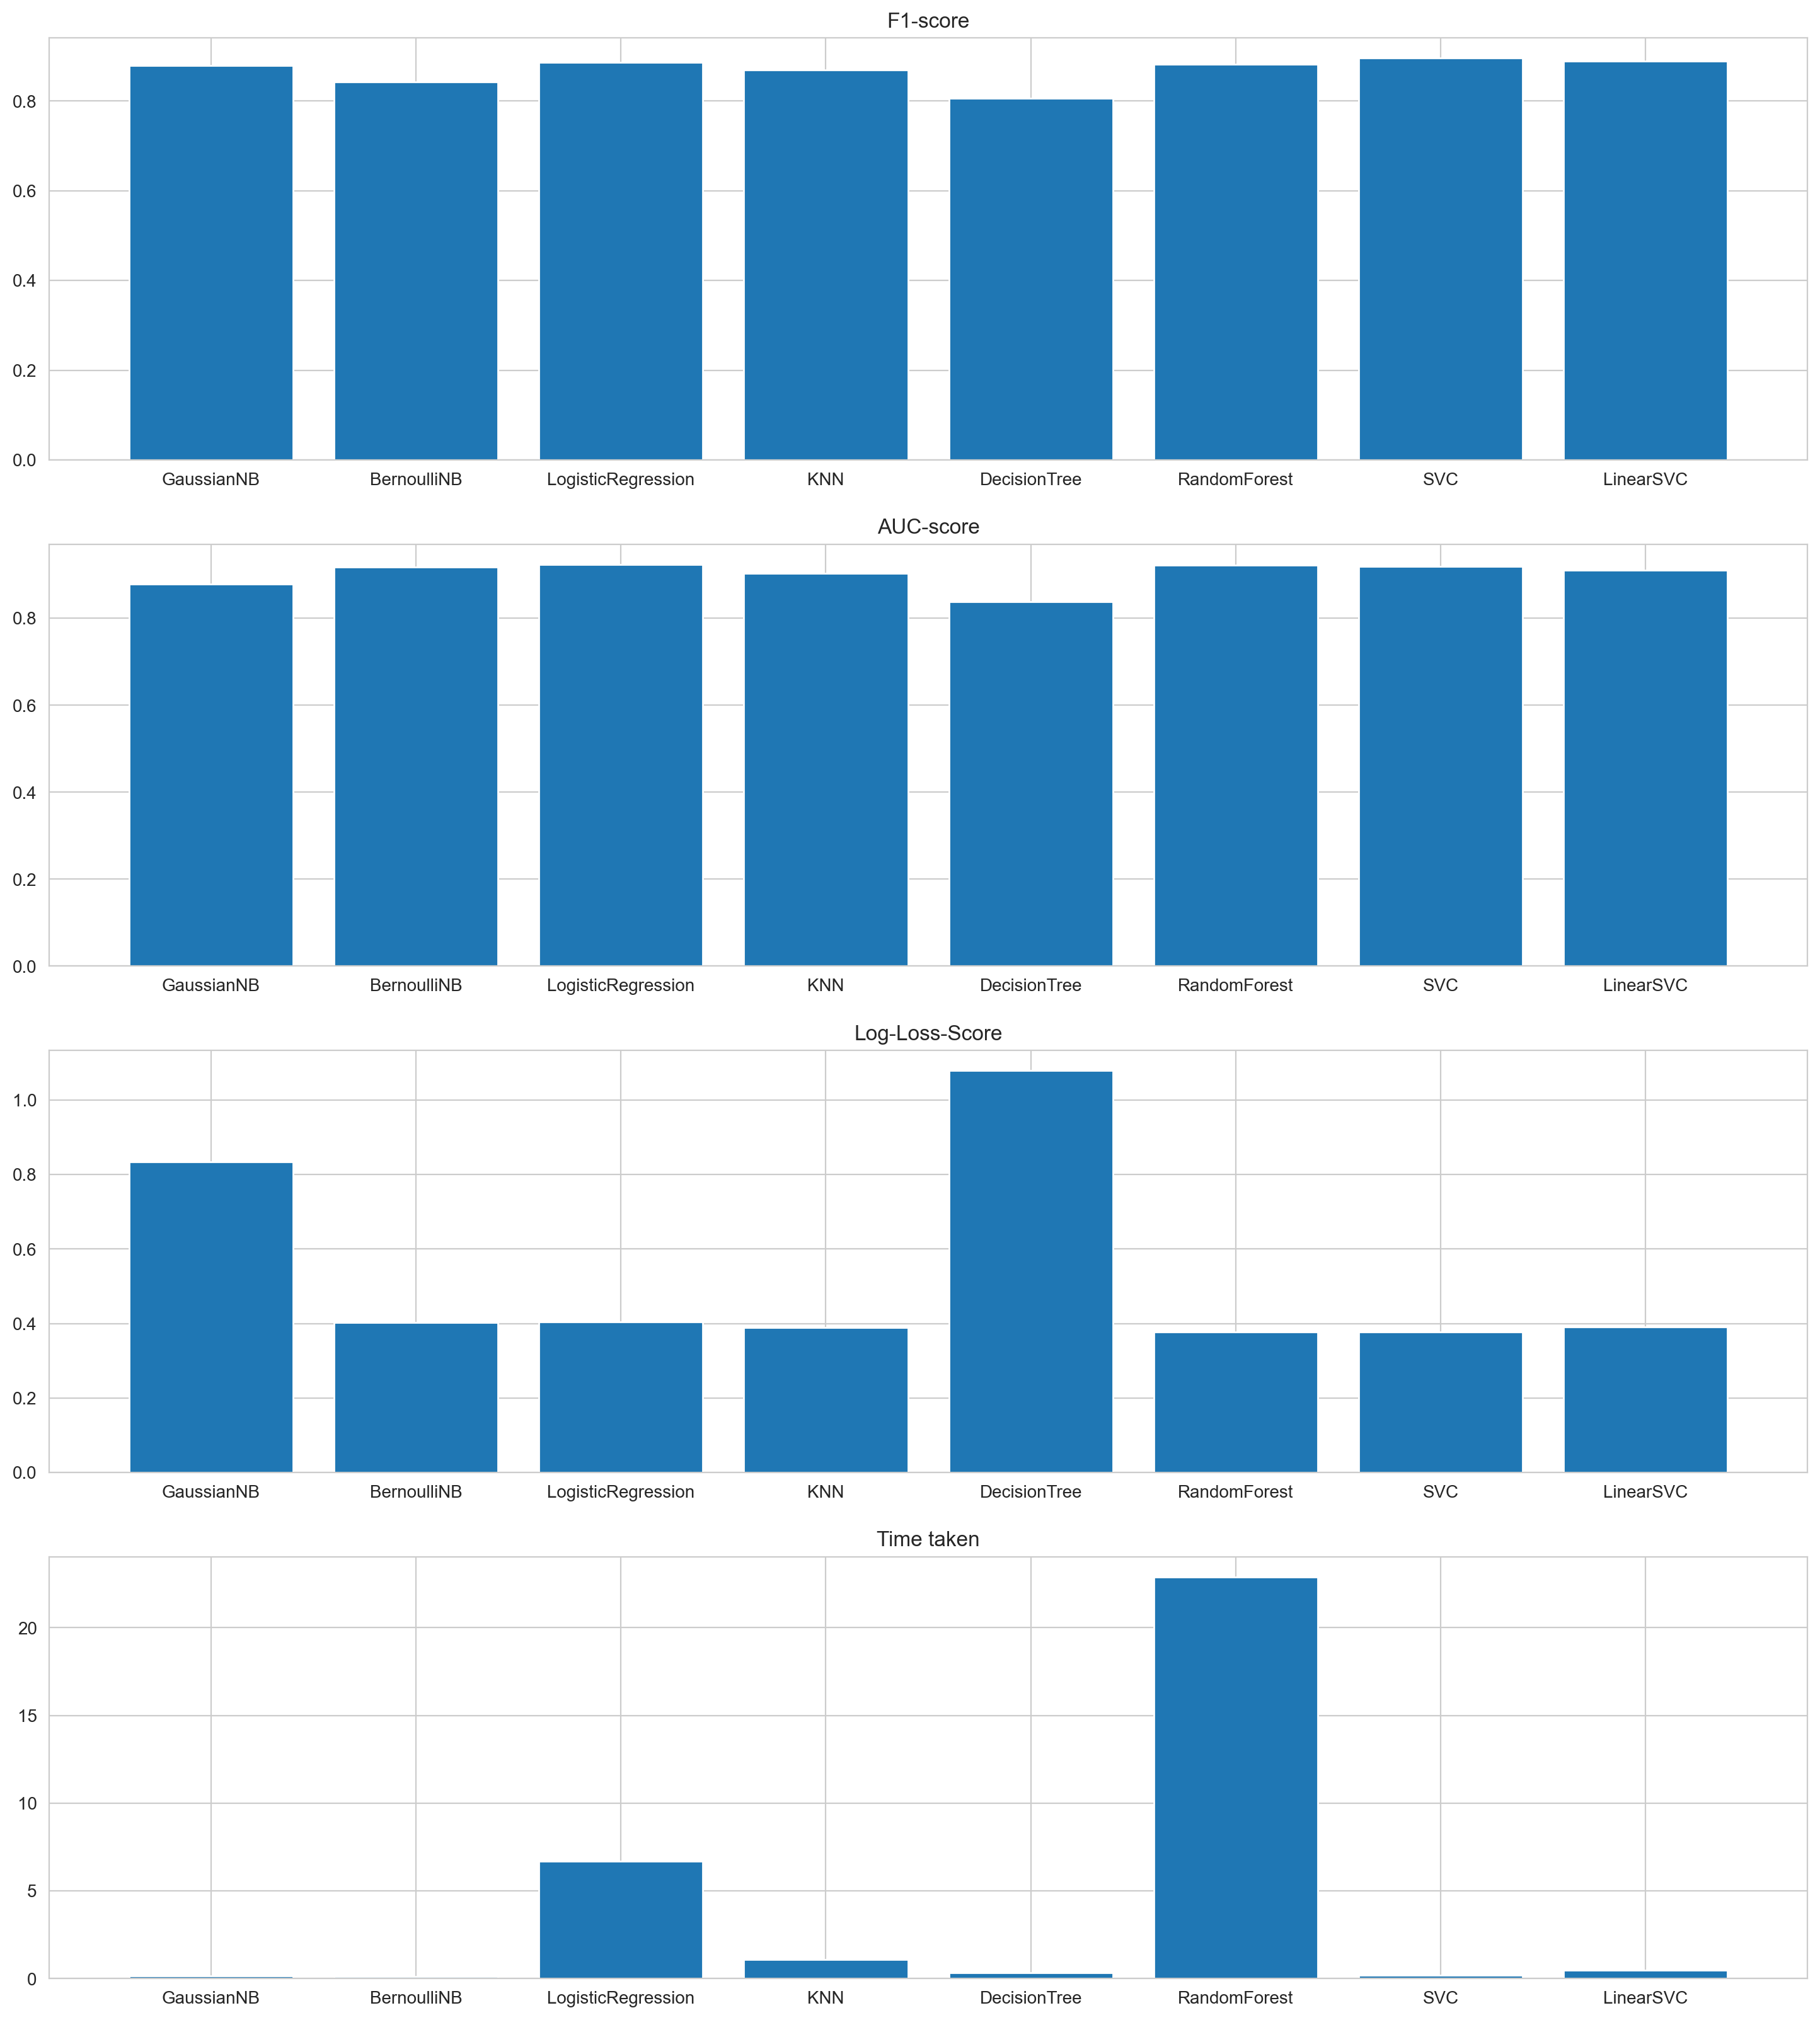

In [121]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(opt_models_tuned.model, opt_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(opt_models_tuned.model, opt_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(opt_models_tuned.model, opt_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(opt_models_tuned.model, opt_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

### Logistic Regression Random using GridSearchCV: select best set of parameters

In [130]:
# pass in parameters of all these values in the grids, see which gives the best score.
param_grid = {'C': [0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), 
                    param_grid, cv=5, scoring='f1') # cv=5 refers to cross validation in the training dataset

grid.fit(x_train, y_train)

print("Best cross-validation score: {:.3f}".format(grid.best_score_))   # scoring='f1'; or default using accuracy
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

#make prediction
lr = grid.best_estimator_
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Testing metrics after grid search')
print('Accuracy', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))

Best cross-validation score: 0.841
Best parameters:  {'C': 0.01}
Best estimator:  LogisticRegression(C=0.01, solver='liblinear')
Testing metrics after grid search
Accuracy 0.8524590163934426
Precision 0.8787878787878788
Recall 0.8529411764705882


### Random Forest using GridSearchCV: select best set of parameters

In [138]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [139]:
# Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],   
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)             
cv.fit(x_train, y_train)
print_results(cv)

BEST PARAMS: {'max_depth': 2, 'n_estimators': 256}

0.794 (+/-0.126) for {'max_depth': 2, 'n_estimators': 8}
0.802 (+/-0.085) for {'max_depth': 2, 'n_estimators': 16}
0.823 (+/-0.103) for {'max_depth': 2, 'n_estimators': 32}
0.81 (+/-0.106) for {'max_depth': 2, 'n_estimators': 64}
0.827 (+/-0.104) for {'max_depth': 2, 'n_estimators': 128}
0.843 (+/-0.091) for {'max_depth': 2, 'n_estimators': 256}
0.835 (+/-0.081) for {'max_depth': 2, 'n_estimators': 512}
0.794 (+/-0.127) for {'max_depth': 4, 'n_estimators': 8}
0.802 (+/-0.109) for {'max_depth': 4, 'n_estimators': 16}
0.802 (+/-0.14) for {'max_depth': 4, 'n_estimators': 32}
0.839 (+/-0.085) for {'max_depth': 4, 'n_estimators': 64}
0.802 (+/-0.091) for {'max_depth': 4, 'n_estimators': 128}
0.827 (+/-0.09) for {'max_depth': 4, 'n_estimators': 256}
0.819 (+/-0.106) for {'max_depth': 4, 'n_estimators': 512}
0.773 (+/-0.154) for {'max_depth': 8, 'n_estimators': 8}
0.786 (+/-0.114) for {'max_depth': 8, 'n_estimators': 16}
0.81 (+/-0.081) for 

### Feature importance

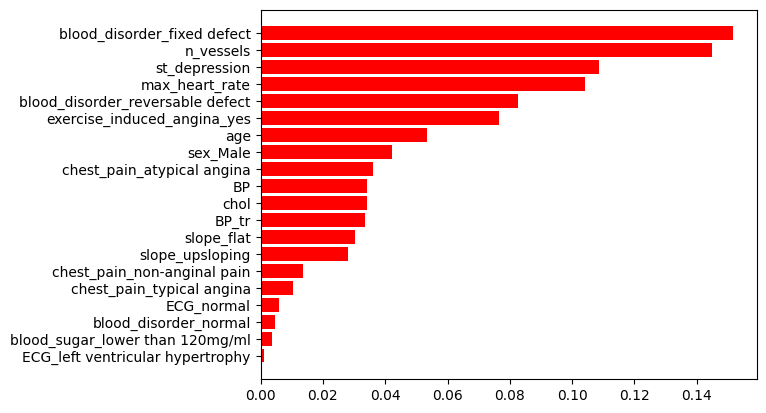

In [48]:
# Generate feature importance plot
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [x_train.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

### SVM using GridSearchCV 

In [132]:
# train the model on train set
model = SVC()
model.fit(x_train, y_train)
  
# print prediction results
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.88      0.88      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [133]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
svc_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
svc_grid.fit(x_train, y_train)
print_results(svc_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.551 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.531 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.542 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.542 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.542 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.729 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.735 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

NameError: name 'print_results' is not defined

### Plot ROC curves of improved models

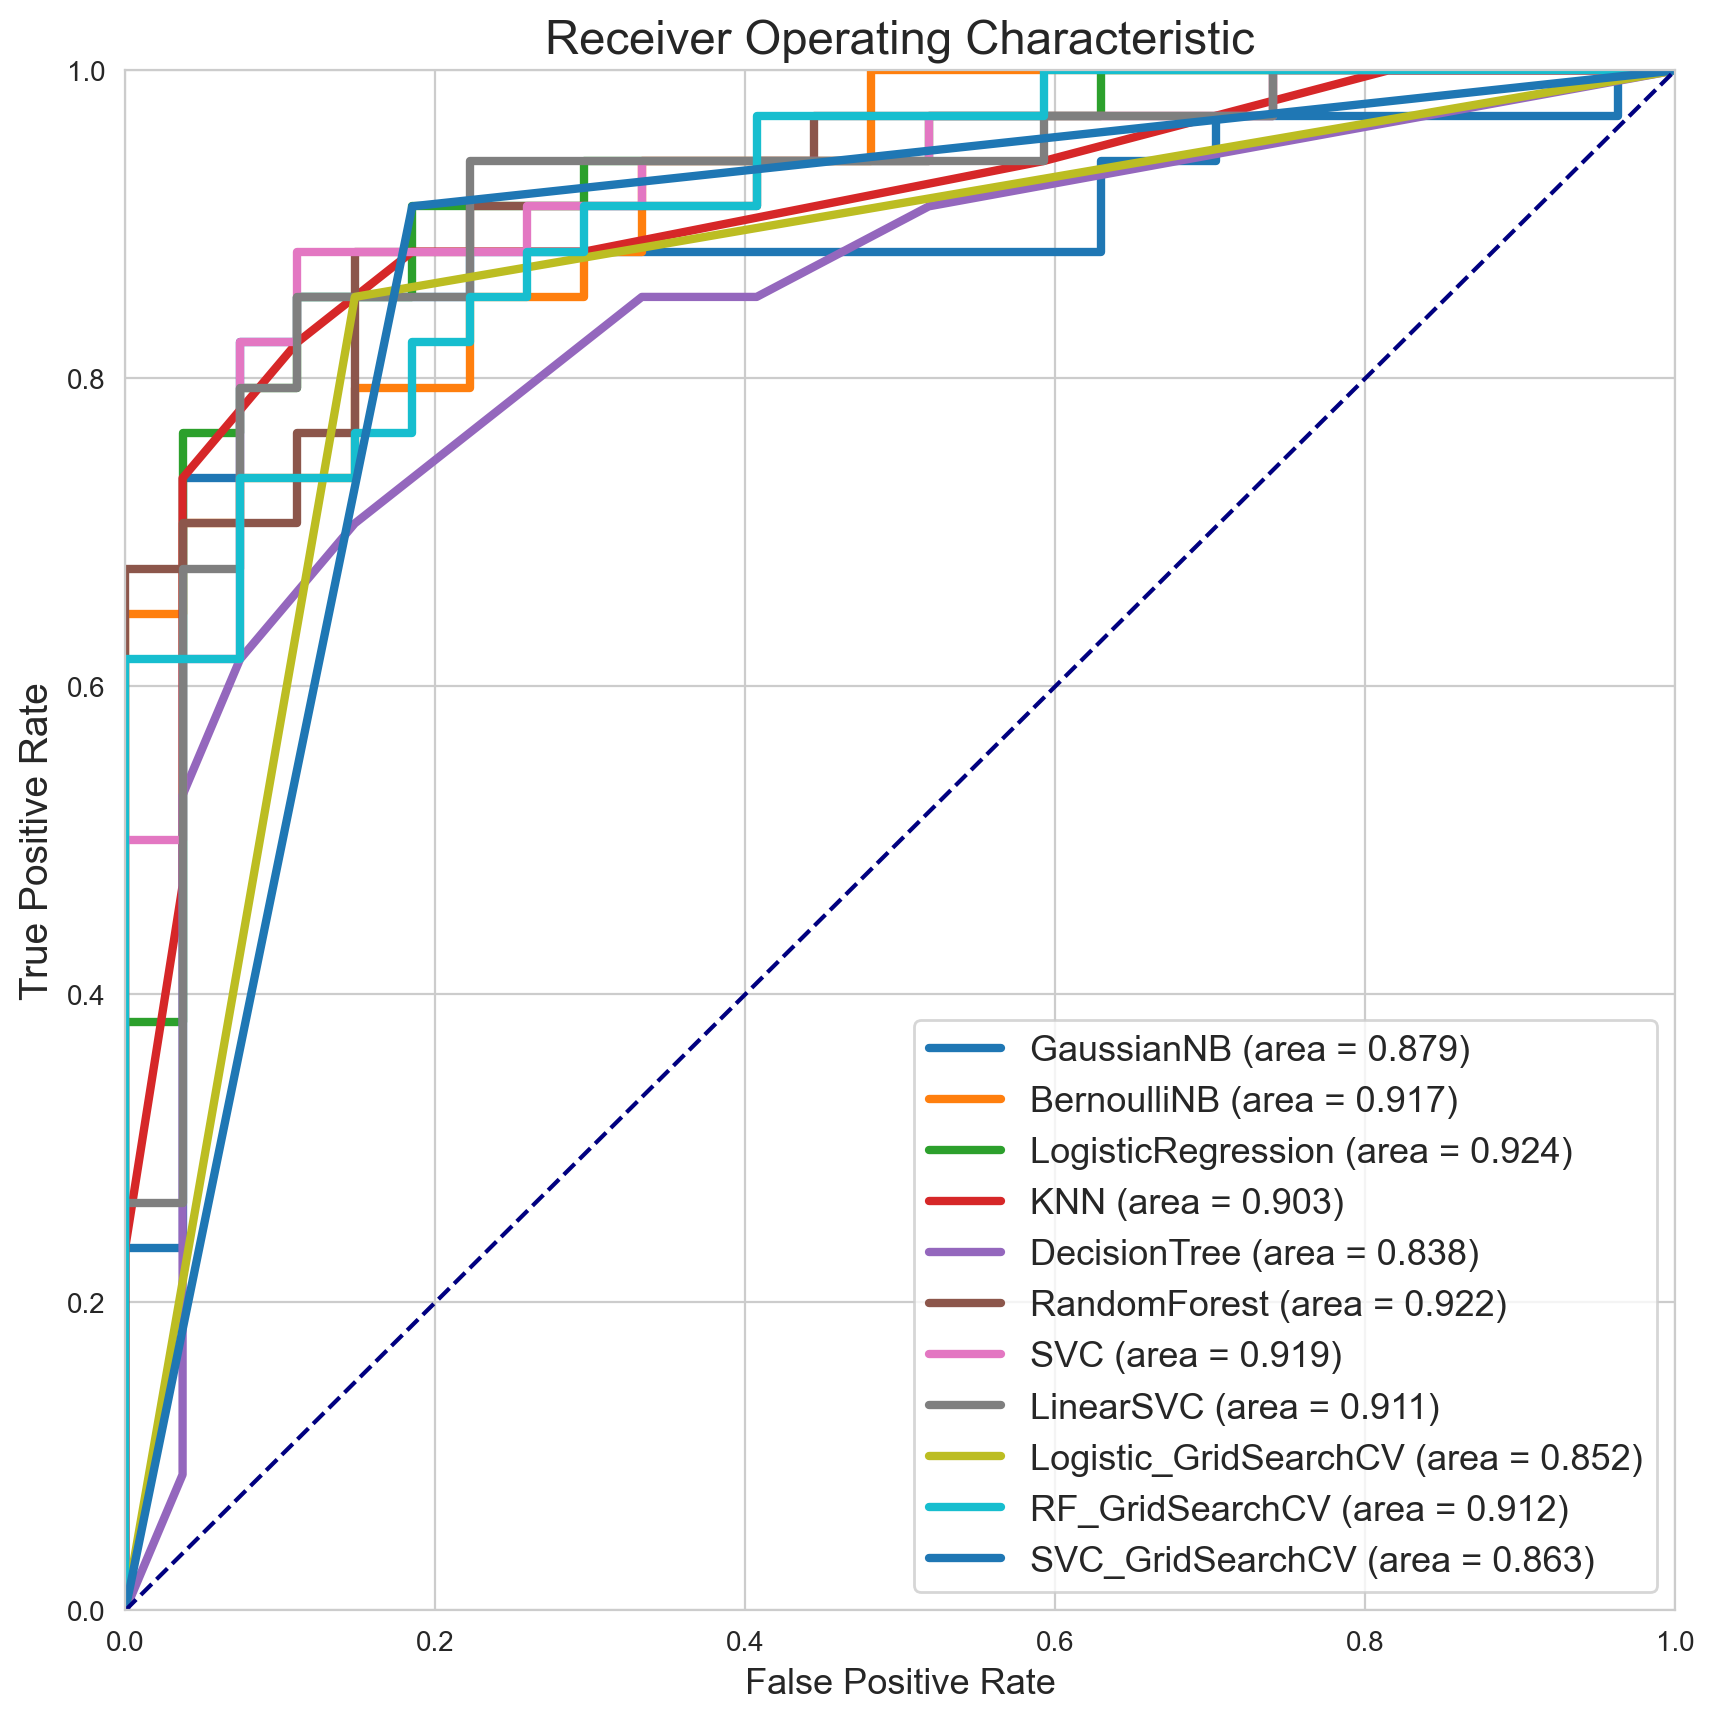

In [140]:
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=opt_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = lr.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='Logistic_GridSearchCV (area = %0.3f)' % auc(fpr, tpr))

y_pred = cv.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='RF_GridSearchCV (area = %0.3f)' % auc(fpr, tpr))

y_pred = svc_grid.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='SVC_GridSearchCV (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

Diagnostic tests are often sold, marketed, cited and used with sensitivity and specificity as the headline metrics. Sensitivity and specificity are defined as,

Sensitivity = TruePositives/TruePositives+FalseNegatives

Specificity = FalseNegatives/FalseNegatives+TruePositives

**Specificity and Sensitivity**

In [79]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8214285714285714
Specificity :  0.8787878787878788


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

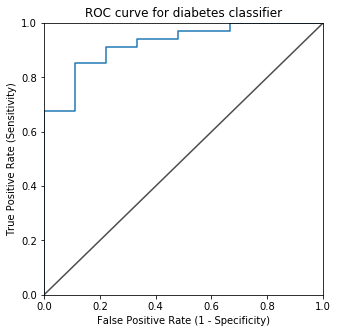

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="-", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [81]:
# let's check the auc score

from sklearn.metrics import auc
auc = auc(fpr, tpr)
print("AUC Score :", auc)

AUC Score : 0.9237472766884531


**Explanation**

In [0]:
!pip install eli5

In [0]:
!pip install shap

In [0]:
!pip install pdpbox

In [0]:
# importing ML Explanability Libraries


#for purmutation importance
import eli5 
from eli5.sklearn import PermutationImportance

#for SHAP values
import shap 
from pdpbox import pdp, info_plots #for partial plots


In [86]:
# let's check the importance of each attributes

perm = PermutationImportance(model, random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

**Partial Dependence Plot for Top 5 Features**

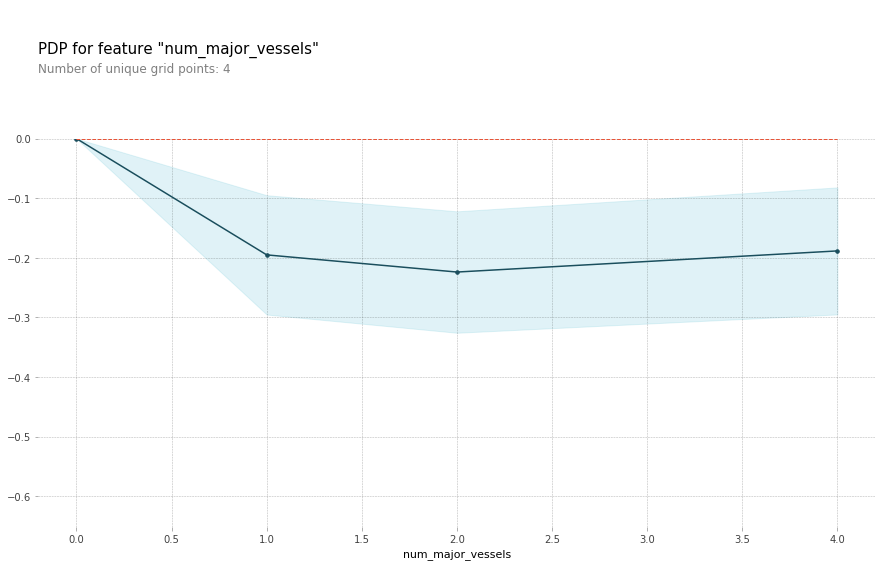

In [88]:
# plotting the partial dependence plot for num_major_vessels

base_features = data.columns.values.tolist()

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


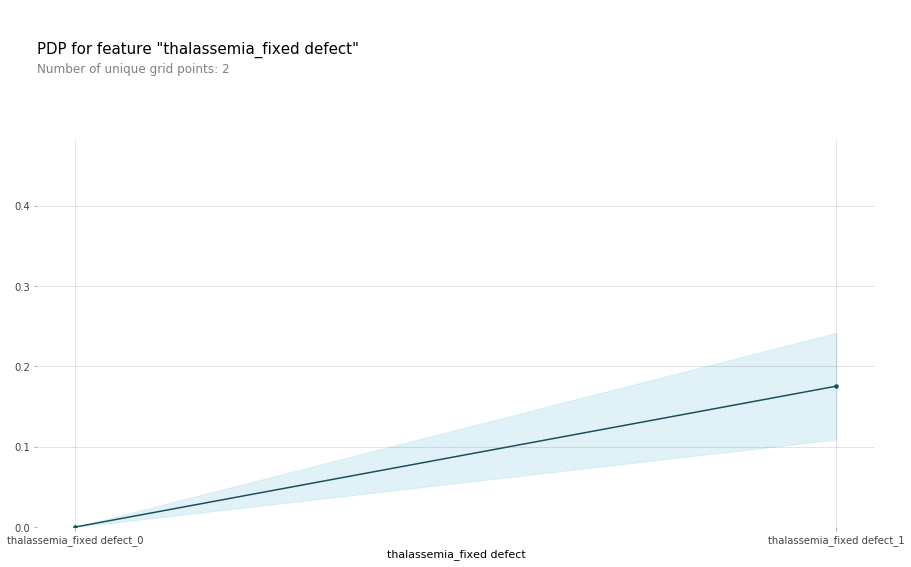

In [89]:
# let's plot the partial dependence plot for thalassemia_fixed defect

base_features = data.columns.values.tolist()

feat_name = 'thalassemia_fixed defect'
pdp_dist = pdp.pdp_isolate(model = model, dataset = x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


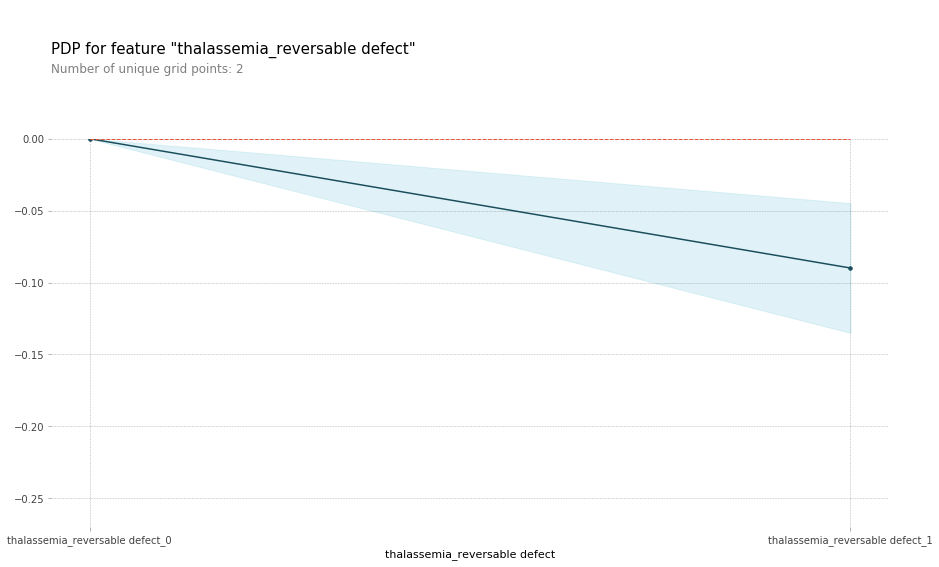

In [90]:

# let's plot the partial dependence plot for thalassemia_reversable defect

base_features = data.columns.values.tolist()

feat_name = 'thalassemia_reversable defect'
pdp_dist = pdp.pdp_isolate(model = model, dataset = x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

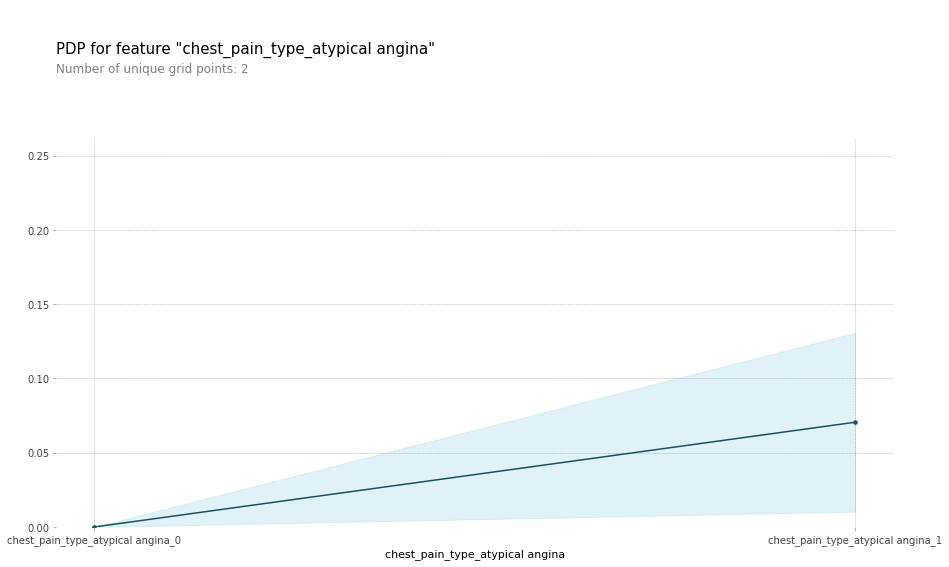

In [93]:
# plotting a partial dependence graph for chest_pain_type_atypical angina

base_features = data.columns.values.tolist()

feat_name = 'chest_pain_type_atypical angina'
pdp_dist = pdp.pdp_isolate(model = model, dataset = x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


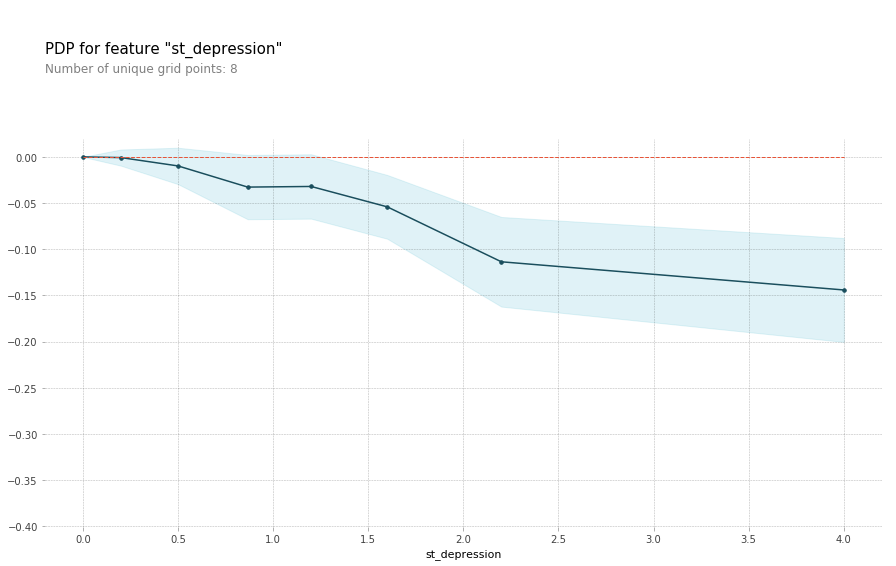

In [94]:
# plotting a partial dependence graph for st_depression


base_features = data.columns.values.tolist()

feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model = model, dataset = x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


TypeError: ignored

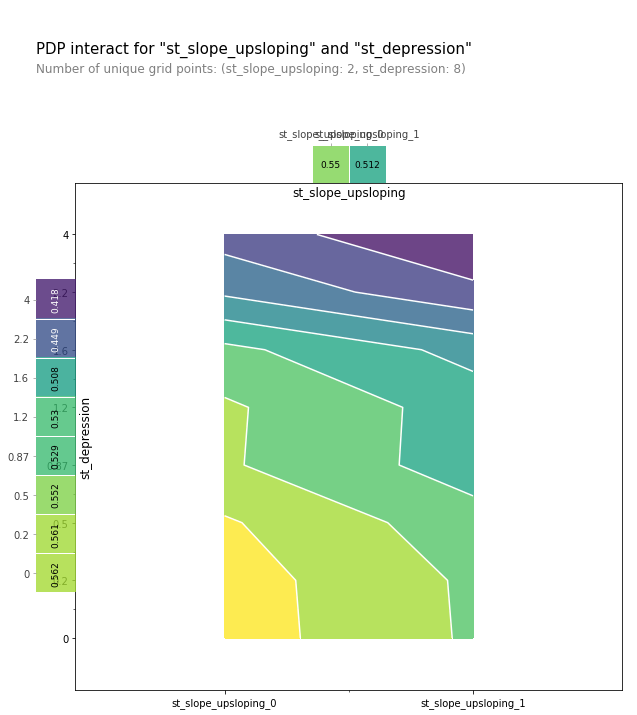

In [108]:
# interactive partial dependence plots for st_depression

inter1 = pdp.pdp_interact(model=model, dataset=x_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'],
                          num_grid_points=[10, 10], percentile_ranges=[None, None],)

fig, axis = pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], x_quantile = True, plot_pdp = True)
plt.show()


TypeError: ignored

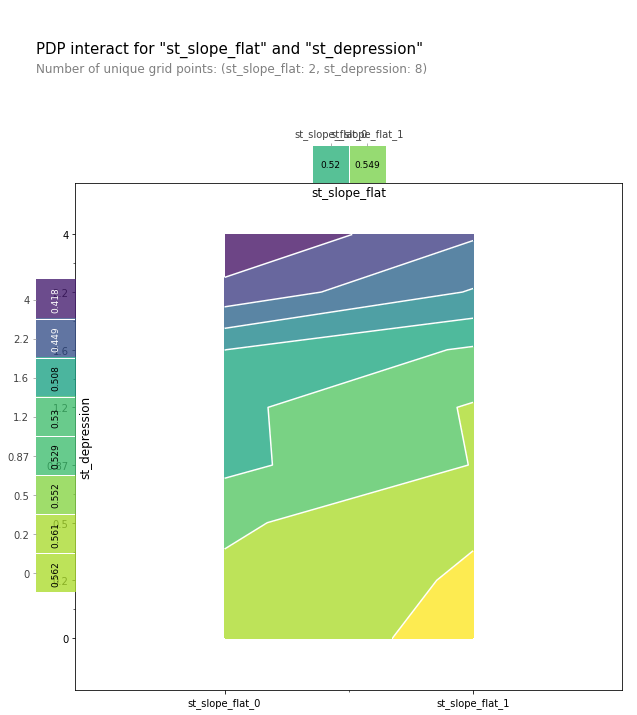

In [103]:
inter1  =  pdp.pdp_interact(model=model, dataset=x_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour', x_quantile = True,
                      plot_pdp = True)
plt.show()

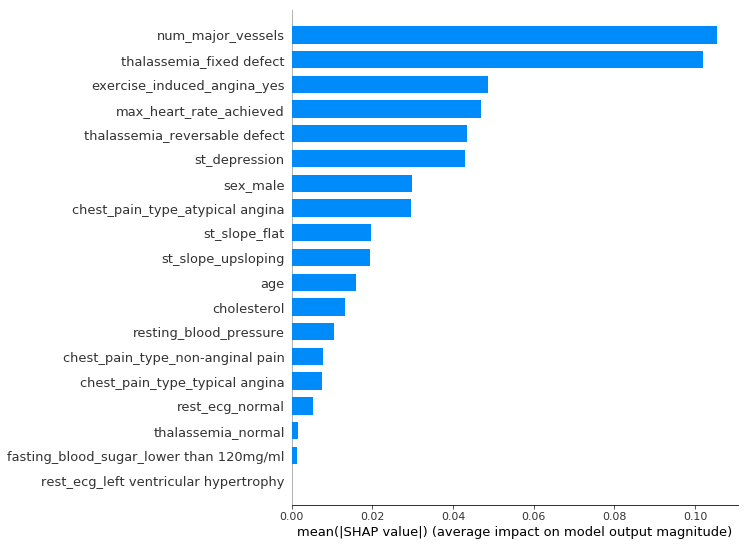

In [109]:
# let's see the shap values

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values[1], x_test, plot_type="bar")

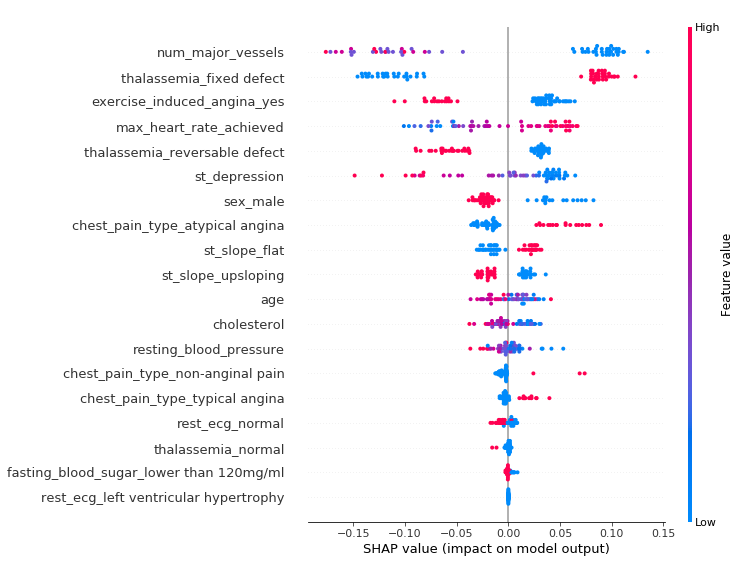

In [111]:
shap.summary_plot(shap_values[1], x_test)


In [0]:
# let's create a function to check the patient's conditions

def patient_analysis(model, patient):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(patient)
  shap.initjs()
  return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

**Report for the First Patient**

In [113]:
# let's do some real time prediction for patients

patients = x_test.iloc[1,:].astype(float)
patient_analysis(model, patients)

**Report for the Second Patient**

In [114]:
patients = x_test.iloc[:, 2].astype(float)
patient_analysis(model, patients)

**Report for the Third Patient**

In [117]:
patients = x_test.iloc[:,3].astype(float)
patient_analysis(model, patients)

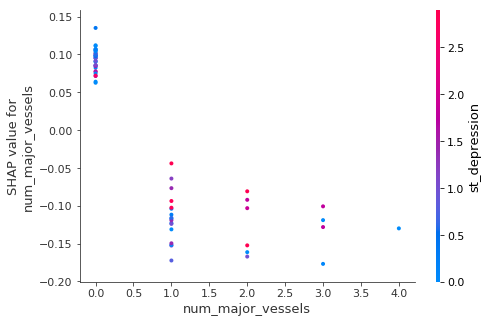

In [118]:
# dependence plot

shap.dependence_plot('num_major_vessels', shap_values[1], x_test, interaction_index = "st_depression")

**Force Plot**

In [120]:
shap_values = explainer.shap_values(x_train.iloc[:50])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test.iloc[:50])